# Milestone IA Team Project
##### *By Joseph Higgins, Marin Petel and Roy Spencer*

## Overview
This project is an attempt to identify key characteristics that make startups successful. We chose this topic because all three of us have an interest in financial services and hope to learn more about private equity and private debt.

Ultimately our goal is to better inform the buy-side of these firms. This project is intended to be a first step towards a machine learning business valuation tool that can help firms to better assess company values and pricing factors when conducting a merger or an acquisition.

Numerous researchers have tried (with mixed results) to use machine learning techniques to identify success factors, mostly through supervised classification models.

Identifying a successful startup target is extremely challenging - according to Forbes, 90% of startups fail. We defined success for startups as startups that went through an IPO or were acquired. To note - a small number of startups manage to reach a valuation of over USD 1 billion and are generally referred to as ‘unicorns’.

## Sections
- Setup
- Data Cleansing
- Exploratory Data Analysis

## Setup
Importing the libraries/packages/modules required for our analysis

In [2]:
# Commented out for brevity
# !pip install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import networkx as nx
import glob
import scipy.stats
import itertools
import plotly.graph_objects as go
import warnings
import statsmodels

from sklearn.feature_selection import mutual_info_classif

warnings.filterwarnings('ignore') # Supressing Unneccessary Warnings

##### Importing Our Data

The CrunchBase data is integrated via Google Drive. You can manage this integration on the right hand side of deepnote - also I used my personal drive to upload our files to the datasets directory. The below is a linux/shell command to list all files in the datasets directory and the following cell is a loop that imports every dataset in my drive. It then renames the files and allows us to index in a dictionary format. For example - if you want to view the 'ipos' dataframe call `df_dict['ipos']` and if you wanted to view the 'id' column within 'ipos' call `df_dict['ipos'].id`.

For the Crunchbase data files below - 'degrees.csv', 'funding_rounds.csv', 'investments.csv', 'milestones.csv', 'objects.csv', 'offices.csv', 'relationships.csv' and 'startups.csv' had to be uploaded as a head file (top 100 rows) due to their massive sizes. You can get the full Crunchbase file(s) from [Kaggle](https://www.kaggle.com/datasets/justinas/startup-investments) or my [Drive](https://drive.google.com/drive/folders/13Fg4RJoqTvuJDX7-oseyG8dVBdBViEC9?usp=sharing). 

For the WDI data files below - 'data.csv' and 'footnote.csv' had to be uploaded as a head file (top 100 rows) due to their massive sizes. You can get the full WDI file(s) from the administrative location or from my [Drive](https://drive.google.com/drive/folders/1NawpK9fmboy1iPQ786qjet3khqwgOs9G?usp=sharing). 

In [1]:
# Changing into our preferred directory and listing its contents (not the most efficient approach - but the only one that works for certain versions of ipython)

%cd data
%cd datasets 
%ls

c:\Users\Broseph Higgins\OneDrive\Documents\UMSI_MADS\SIADS_593\Team_Project\05-higgins-spencer-petel\src\data
c:\Users\Broseph Higgins\OneDrive\Documents\UMSI_MADS\SIADS_593\Team_Project\05-higgins-spencer-petel\src\data\datasets
 Volume in drive C is OS
 Volume Serial Number is FC83-6993

 Directory of c:\Users\Broseph Higgins\OneDrive\Documents\UMSI_MADS\SIADS_593\Team_Project\05-higgins-spencer-petel\src\data\datasets

10/15/2022  08:27 PM    <DIR>          .
10/15/2022  08:27 PM    <DIR>          ..
10/15/2022  12:50 PM         2,099,350 acquisitions.csv
10/15/2022  12:50 PM        11,955,128 degrees.csv
10/15/2022  12:50 PM               650 funding_comp.csv
10/15/2022  12:50 PM        13,134,510 funding_rounds.csv
10/15/2022  12:50 PM           356,805 funds.csv
10/15/2022  12:50 PM         5,374,133 investments.csv
10/15/2022  12:50 PM           143,038 ipos.csv
10/15/2022  12:50 PM         9,776,144 milestones.csv
10/15/2022  12:50 PM       284,809,039 objects.csv
10/15/2022  

In [3]:
# Changing into our preferred directory and listing its contents (not the most efficient approach - but the only one that works for certain versions of ipython)

%cd ../
%cd datasets_wdi 
%ls

c:\Users\Broseph Higgins\OneDrive\Documents\UMSI_MADS\SIADS_593\Team_Project\05-higgins-spencer-petel\src\data
c:\Users\Broseph Higgins\OneDrive\Documents\UMSI_MADS\SIADS_593\Team_Project\05-higgins-spencer-petel\src\data\datasets_wdi
 Volume in drive C is OS
 Volume Serial Number is FC83-6993

 Directory of c:\Users\Broseph Higgins\OneDrive\Documents\UMSI_MADS\SIADS_593\Team_Project\05-higgins-spencer-petel\src\data\datasets_wdi

10/15/2022  08:27 PM    <DIR>          .
10/15/2022  08:27 PM    <DIR>          ..
10/15/2022  01:04 PM           157,015 country.csv
10/15/2022  01:04 PM         1,023,586 country_series.csv
10/15/2022  01:04 PM       208,361,905 data.csv
10/15/2022  01:04 PM        67,319,390 foot_note.csv
10/15/2022  01:04 PM         3,770,200 series.csv
10/15/2022  01:04 PM            51,756 series_time.csv
               6 File(s)    280,683,852 bytes
               2 Dir(s)  350,698,328,064 bytes free


In [4]:
# Changing into our preferred directory and listing its contents (not the most efficient approach - but the only one that works for certain versions of ipython)

%cd ../

c:\Users\Broseph Higgins\OneDrive\Documents\UMSI_MADS\SIADS_593\Team_Project\05-higgins-spencer-petel\src\data


In [7]:
# Importing our Crunchbase data

path = 'datasets/'
all_files = glob.glob(path + "*.csv")

filename_clean_list = []
for filename in all_files:
    filename_clean = filename.replace(path, '')
    filename_clean = filename_clean.replace('.csv', '').replace("\\","/")
    filename_clean_list.append(filename_clean)

df_dict = {}
for filename in filename_clean_list:
    df = pd.read_csv(filename + '.csv')
    integer_columns = df.select_dtypes('integer').columns
    float_columns = df.select_dtypes('float').columns
    
    # downcast numerical types to gain memory
    for col in integer_columns:
        df[col] = pd.to_numeric(df[col],downcast='integer')
    for col in float_columns:
        df[col] = pd.to_numeric(df[col],downcast='float')
    
    df_dict[filename.replace('datasets/', '')] = df

C:\Users\Broseph Higgins\AppData\Local\Temp\ipykernel_5104\3106859899.py:14: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename + '.csv')


In [8]:
# Importing our WDI data

path = 'datasets_wdi/'
all_files = glob.glob(path + "*.csv")

filename_clean_list_wdi = []
for filename in all_files:
    filename_clean = filename.replace(path, '')
    filename_clean = filename_clean.replace('.csv', '').replace("\\","/")
    filename_clean_list_wdi.append(filename_clean)

df_dict_wdi = {}
for filename in filename_clean_list_wdi:
    df = pd.read_csv(filename + '.csv')
    integer_columns = df.select_dtypes('integer').columns
    float_columns = df.select_dtypes('float').columns
    # downcast numerical types to gain memory
    for col in integer_columns:
        df[col] = pd.to_numeric(df[col],downcast='integer')
    for col in float_columns:
        df[col] = pd.to_numeric(df[col],downcast='float')
    df_dict_wdi[filename.replace('datasets_wdi/', '')] = df

In [7]:
# Commented out for brevity
# Importing our Yahoo Finance Data

# ipos['stock_symbol'] = ipos['stock_symbol'].str.strip()

# for ticker in ipos['stock_symbol']:
#     if len(ticker) > 1:
#         print(ticker)
#     else:
#         pass

# all_tickers = ipos['stock_symbol'].tolist()
# results = {}
# results_main = []

# for ticker in all_tickers:
#     results[ticker] = yf.download(ticker, start='2000-01-01', end='2021-11-17', progress=False)
#     results[ticker]['startup'] = ticker
#     results_main.append(results[ticker])

Let's get some basic information on each csv file.

In [8]:
# Commented out for brevity

# for i in filename_clean_list:
#     print(i)
#     print(df_dict[i].info())
#     print('')

## Data Cleansing

### Acquisitions

In [9]:
# Commented out for brevity

# Overall Dataframe Information
# df_dict['acquisitions'].info()

# Term Code
# df_dict['acquisitions'].term_code.unique()

# Price Amount
# df_dict['acquisitions'].price_amount.min()
# df_dict['acquisitions'].price_amount.max()
# df_dict['acquisitions'] = df_dict['acquisitions'][df_dict['acquisitions'].price_amount < 2600000000000.0]
# fig = px.histogram(df_dict['acquisitions'], x="price_amount", nbins=30, width=800, height=400, title='Price Amount Distribution')
# fig.show()

# Price Currency Code
# df_dict['acquisitions'].price_currency_code.unique()
# df_dict['acquisitions'].groupby(['price_currency_code'])['price_currency_code'].count()

# Acquired At
# pd.to_datetime(df_dict['acquisitions'].acquired_at).min()
# pd.to_datetime(df_dict['acquisitions'].acquired_at).max()

# Source URL
# print("We have URLs for about", round(df_dict['acquisitions'].source_url.count()/9561*100, 2), "% of ids")

# Source Description
# print("We have URL descriptions for about", round(df_dict['acquisitions'].source_description.count()/9561*100, 2), "% of ids")

# Created At
# pd.to_datetime(df_dict['acquisitions'].created_at).min()
# pd.to_datetime(df_dict['acquisitions'].created_at).max()

# Updated At 
# pd.to_datetime(df_dict['acquisitions'].updated_at).min()
# pd.to_datetime(df_dict['acquisitions'].updated_at).max()

In [51]:
# Joining Acquisitions to our base Dataset 'Startup' to delimit our volumes to only firms in scope of analysis
df_dict['startup'].id = df_dict['startup'].id.astype(str)
df_dict['acquisitions'].acquired_object_id = df_dict['acquisitions'].acquired_object_id.astype(str)
acquisitions = df_dict['startup'].merge(df_dict['acquisitions'], left_on='id', right_on='acquiring_object_id', how='left')

The acquisitions file contains information surrounding the price paid for firms that were acquired. The distribution of prices paid (in US dollars) is unimodal with the majority of firms being acquired for around 0-2B USD. There was one significant outlier acquired for north of 2T USD. We had URLs documented and Source Descriptions for ~90% of all firms in our dataset. 

### Degrees

In [11]:
# Commented out for brevity

# Overall Dataframe Information
# df_dict['degrees'].head()
# df_dict['degrees'].info()
# df_dict['degrees'].degree_type.unique()

# Degree Type
# df_degree_type = pd.DataFrame(df_dict['degrees'].degree_type, columns=['degree_type'])
# df_degree_type['degree_type'] = df_degree_type['degree_type'].replace(['MBA With Honors'],'MBA')
# df_degree_type['degree_type'] = df_degree_type['degree_type'].replace(['BA (Hons) First Class'],'BA')
# df_degree_type['degree_type'] = df_degree_type['degree_type'].replace(['BASC'],'BS')
# df_degree_type['degree_type'] = df_degree_type['degree_type'].replace(["Master's Degree"],'Masters Degree')
# df_degree_type['degree_type'] = df_degree_type['degree_type'].replace(['masters degree'],'Masters Degree')
# df_degree_type_counts = pd.DataFrame(df_dict['degrees'].groupby(['degree_type'])['degree_type'].count().sort_values(ascending=False))
# df_degree_type_counts.head()

# Subject
# df_dict['degrees'].subject.unique()
# df.loc[df['B'].str.contains(string,regex=False), 'C'] = 'exist'

# Institution
# df_dict['degrees'].groupby(['institution'])['institution'].count().sort_values(ascending=False)

# Graduated At
# pd.to_datetime(df_dict['degrees'].graduated_at).min()
# pd.to_datetime(df_dict['degrees'].graduated_at).max()

# Created At
# pd.to_datetime(df_dict['degrees'].created_at).min()
# pd.to_datetime(df_dict['degrees'].created_at).max()

# Updated At
# pd.to_datetime(df_dict['degrees'].updated_at).min()
# pd.to_datetime(df_dict['degrees'].updated_at).max()

In [12]:
# Joining Acquisitions to our base Dataset 'Startup' to delimit our volumes to only firms in scope of analysis
# Join Startup -> Relationship -> People -> Degrees

df_0 = df_dict['startup'].merge(df_dict['relationships'], left_on='id', right_on='relationship_object_id', how='left') 
df_1 = df_0.merge(df_dict['degrees'], left_on='person_object_id', right_on='object_id', how='left')
degrees = df_1[['name', 'sucessfull', 'degree_type', 'subject', 'institution']]

The degrees file contains information surrounding the level and type of degrees held by those staffed at our startup firms. In general - the most frequently obtained degree was a Bachelor of Science. Masters in Business Administration came in second place and unsurprisingly in third place, Bachelor of Arts degrees. The least frequently held degree (but still fairly popular) was a PHD. 

### Funding Rounds

In [13]:
# Commented out for brevity

# Overall Dataframe Information
# df_dict['funding_rounds'].info()

# Funded At
# pd.to_datetime(df_dict['funding_rounds'].updated_at).min()
# pd.to_datetime(df_dict['funding_rounds'].updated_at).max()

# Funding Round Type
# df_dict['funding_rounds'].funding_round_type.unique()
# df_dict['funding_rounds'].groupby(['funding_round_type'])['funding_round_type'].count().sort_values(ascending=False)

# Funding Round Code
# df_dict['funding_rounds'].funding_round_code.unique()
# df_dict['funding_rounds'].groupby(['funding_round_code'])['funding_round_code'].count().sort_values(ascending=False)

# Raised Amount USD
# df_dict['funding_rounds'].raised_amount_usd.unique()
# df_dict['funding_rounds'].raised_amount_usd.min()
# df_dict['funding_rounds'].raised_amount_usd.max()

# Raised Amount
# df_dict['funding_rounds'].raised_amount.unique()
# df_dict['funding_rounds'].raised_amount.min()
# df_dict['funding_rounds'].raised_amount.max()

# Raised Currency Code
# df_dict['funding_rounds'].raised_currency_code.unique()
# df_dict['funding_rounds'].groupby(['raised_currency_code'])['raised_currency_code'].count().sort_values(ascending=False)

# Pre Money Valuation USD
# df_dict['funding_rounds'].pre_money_valuation_usd.unique()
# df_dict['funding_rounds'].pre_money_valuation_usd.min()
# df_dict['funding_rounds'].pre_money_valuation_usd.max()

# Pre Money Valuation
# df_dict['funding_rounds'].pre_money_valuation.unique()
# df_dict['funding_rounds'].pre_money_valuation.min()
# df_dict['funding_rounds'].pre_money_valuation.max()

# Pre Money Currency Code
# df_dict['funding_rounds'].pre_money_currency_code.unique()
# df_dict['funding_rounds'].groupby(['pre_money_currency_code'])['pre_money_currency_code'].count().sort_values(ascending=False)

# Post Money Valuation USD
# df_dict['funding_rounds'].post_money_valuation_usd.unique()
# df_dict['funding_rounds'].post_money_valuation_usd.min()
# df_dict['funding_rounds'].post_money_valuation_usd.max()

# Post Money Valuation
# df_dict['funding_rounds'].post_money_valuation.unique()
# df_dict['funding_rounds'].post_money_valuation.min()
# df_dict['funding_rounds'].post_money_valuation.max()

# Post Money Currency Code 
# df_dict['funding_rounds'].post_money_currency_code.unique()
# df_dict['funding_rounds'].groupby(['post_money_currency_code'])['post_money_currency_code'].count().sort_values(ascending=False)

# Participants
# df_dict['funding_rounds'].participants.unique()
# df_dict['funding_rounds'].participants.min()
# df_dict['funding_rounds'].participants.max()

In [14]:
# Joining Acquisitions to our base Dataset 'Startup' to delimit our volumes to only firms in scope of analysis

funding_rounds = df_dict['startup'].merge(df_dict['funding_rounds'], left_on='id', right_on='object_id', how='left') \
                                   .rename(columns={'name_x': 'name', 'sucessfull_x':'successful'})
funding_rounds = funding_rounds[funding_rounds['id_x'] != 'c:230668'] # Dropping an anomaly record (where post-ipo was acheived but the firm was listed as unsuccessful)
df_dict['funding_rounds'] = funding_rounds.rename(columns={'sucesfull_x': 'successful', 'id_x': 'id'})

The funding rounds file contains a number of useful variables but namely the 'funding_round_type' and 'pre_money_valuation_usd'. There were a number of funding types captured, venture, angel, series a-c, private-equity, crowdfunding, post-ipo and others. The maximum pre money valuation was 15B USD and the minimum was 0 USD. According to our definition of success for a startup (a firm that was either acquired or went public) - there should be no instances of a firm reaching the funding round type of 'post-ipo', but being listed as unsuccessful. This happened with the firm listed under id 'c:230668', so we simply removed it from our scope as the removal of one firm won't have a material effect on our analysis. 

### Funds

In [15]:
# Commented out for brevity

# Overall Dataframe Information
# df_dict['funds'].info()

# Funded At
# pd.to_datetime(df_dict['funds'].updated_at).min()
# pd.to_datetime(df_dict['funds'].updated_at).max()

# Raised Amount
# df_dict['funds'].raised_amount.unique()
# df_dict['funds'].raised_amount.min()
# df_dict['funds'].raised_amount.max()

# Raised Currency Code
# df_dict['funds'].raised_currency_code.unique()
# df_dict['funds'].groupby(['raised_currency_code'])['raised_currency_code'].count().sort_values(ascending=False)

# Source URL
# print("We have URLs for about", round(df_dict['funds'].source_url.count()/9561*100, 2), "% of ids")

# Source Description
# print("We have URL descriptions for about", round(df_dict['funds'].source_description.count()/9561*100, 2), "% of ids")

# Created At
# pd.to_datetime(df_dict['funds'].created_at).min()
# pd.to_datetime(df_dict['funds'].created_at).max()

# Updated At 
# pd.to_datetime(df_dict['funds'].updated_at).min()
# pd.to_datetime(df_dict['funds'].updated_at).max()

This file helps us keep track of the funding startups received over their lifespan. One important note here is that startups have the ability to get money from the same investors at many different times throughout their life cycle (Series A, Series B, C, ect.) with the max investment reaching $89,000,000,000 from a single funding round. 

### Investments

In [16]:
# Commented out for brevity

# Overall Dataframe Information
# df_dict['investments'].head()
# df_dict['investments'].info()

# Created At
# pd.to_datetime(df_dict['investments'].created_at).min()
# pd.to_datetime(df_dict['investments'].created_at).max()

# Updated At 
# pd.to_datetime(df_dict['investments'].updated_at).min()
# pd.to_datetime(df_dict['investments'].updated_at).max()

This file helps us understand when startups were getting their investments- when investors were getting in on their idea to help launch them to success or failure. It is important to note that startups were able to get funding at several different times throughout the process, which is also reflected in this file.

### IPOs

In [17]:
# Commented out for brevity

# Overall Dataframe Information
# df_dict['ipos'].info()

# Valuation Amount
# df_dict['ipos'].valuation_amount.unique()
# df_dict['ipos'].valuation_amount.min()
# df_dict['ipos'].valuation_amount.max()

# Valuation Currency Code
# df_dict['ipos'].valuation_currency_code.unique()
# df_dict['ipos'].groupby(['valuation_currency_code'])['valuation_currency_code'].count().sort_values(ascending=False)

# Raised Amount
# df_dict['ipos'].raised_amount.unique()
# df_dict['ipos'].raised_amount.min()
# df_dict['ipos'].raised_amount.max()

# Raised Currency Code
# df_dict['ipos'].raised_currency_code.unique()
# df_dict['ipos'].groupby(['raised_currency_code'])['raised_currency_code'].count().sort_values(ascending=False)

# Public At
# pd.to_datetime(df_dict['ipos'].public_at).min()
# pd.to_datetime(df_dict['ipos'].public_at).max()

# Stock Symbol
# # Need to remove trading floors
# # Converting the ipos datatype to string from object
# df_dict['ipos'].stock_symbol.astype('str')
# df_dict['ipos'].stock_symbol.unique().tolist()
# df = df_dict['ipos'].stock_symbol.str.split(':', 1, expand=True).rename(columns={0: 'column1', 1: 'column2'})
# df['column2'][(df['column2'].isnull())] = df['column1']
# ipos = df_dict['ipos'].merge(df, left_index=True, right_index=True, how='left').drop(columns=['stock_symbol', 'column1']).rename(columns={'column2': 'stock_symbol'})
# ipos['stock_symbol'] = ipos['stock_symbol'].str.strip()

# for ticker in ipos['stock_symbol']:
#     if len(ticker) > 1:
#         print(ticker)
#     else:
#         pass

In [18]:
# Joining Acquisitions to our base Dataset 'Startup' to delimit our volumes to only firms in scope of analysis

ipos = df_dict['startup'].merge(df_dict['ipos'], left_on='id', right_on='object_id', how='inner')

The ipos file contained a number of valuable variables, but namely the 'raised_amount' and the 'stock_symbol'. The maximum amount raised was ~24.5B USD and the minimum was 0 USD. The distribution of raised amounts (across both successful and unsuccessful startups) was unimodal with the majority of firms raising between 0 USD and 10M USD with a slight right skew due to outliers. 

The stock symbol was one of the most import variables as it's the unique identifier we can use to join to the Yahoo Finance data (to bring in market capitalizations to ultimately determine if company valuations held water post-ipo). The stock symbol column had an interesting format where the trading floor was prefixed to the ticker symbol, so this variable required an extra bit of parsing and cleaning to make useful. 

### Milestones

In [19]:
# Commented out for brevity

# Overall Dataframe Information
# df_dict['milestones'].info()

# Milestone Code 
# df_dict['milestones'].milestone_code.unique()

# Description  
# print("Check NaN in description:", df_dict['milestones'].description.isna().sum())

# Source URL
# print("We have URLs for about", round(df_dict['milestones'].source_url.count()/9561*100, 2), "% of ids")

# Source Description
# print("We have URL descriptions for about", round(df_dict['milestones'].source_description.count()/9561*100, 2), "% of ids")

# Created At
# pd.to_datetime(df_dict['milestones'].created_at).min()
# pd.to_datetime(df_dict['milestones'].created_at).max()

# Updated At 
# pd.to_datetime(df_dict['milestones'].updated_at).min()
# pd.to_datetime(df_dict['milestones'].updated_at).max()

The milestones file includes a ton of essential information on important updates for companies as they journied from startup to successful or unsuccessful startup. This information helps us verify that startups have a linear path to becoming successful as we can see information that impacted them most heavily here. 

### Objects

- Unnecessary data

In [20]:
# retrieve the objects dataframe
objects = df_dict['objects']

# we don't need the following columns: permalink and all the logo information
objects.drop(['permalink','logo_url','logo_width','logo_height'],axis=1,inplace=True)

- Format conversion:

In [21]:
# let's convert all dates which are string in datetime objects
objects[['founded_at','closed_at','first_investment_at','last_investment_at',
'first_funding_at','last_funding_at','first_milestone_at',
'last_milestone_at','created_at','updated_at']] = objects[['founded_at','closed_at',
'first_investment_at','last_investment_at','first_funding_at','last_funding_at','first_milestone_at',
'last_milestone_at','created_at','updated_at']].apply(pd.to_datetime,errors='coerce')

- Missing values

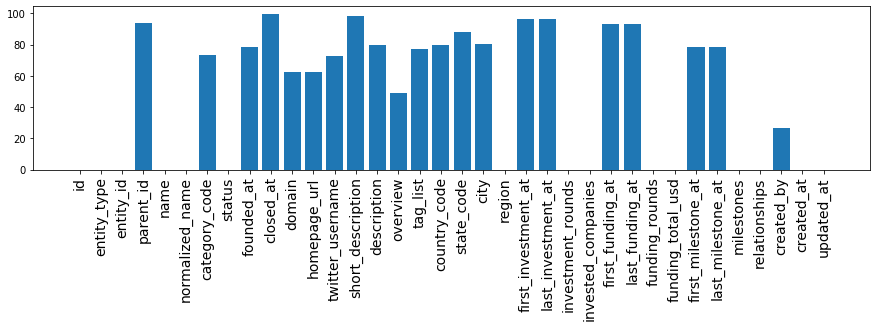

In [22]:
# percentage of missing values overall
objects_missing_overall = 100*objects.isna().sum()/objects.shape[0]
plt.figure(figsize=(15,3))
plt.bar(objects_missing_overall.index,objects_missing_overall)
plt.xticks(rotation=90,fontsize=14)
plt.show()

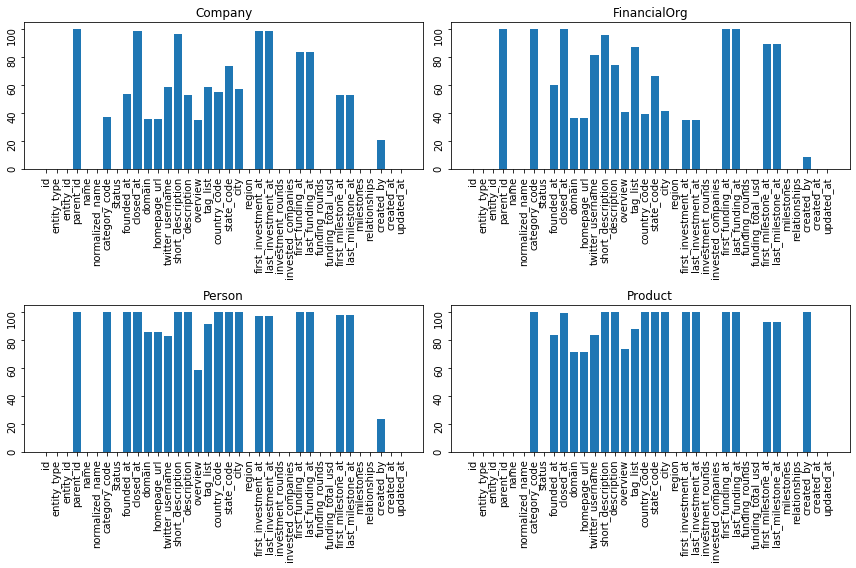

In [23]:
# percentage of missing values by entity_type
fig,axes = plt.subplots(2,2,figsize=(12,8))
index = -1
for name, group in objects.groupby('entity_type'):
    index += 1
    missing_by_type = 100*group.isna().sum()/group.shape[0]
    axes.flatten()[index].bar(missing_by_type.index,missing_by_type)
    axes.flatten()[index].set_title(name)
    axes.flatten()[index].tick_params(labelrotation=90,labelsize=10)
plt.tight_layout()

Let us look at the missing features one by one. We indicate in bold what we foresee as a potential challenges.

- parent_id: Only missing for non product. It makes sense, as for products it enables to map to a company, the relationship is many to one.

- category code: Indicates the type of industry. It is only an issue for Company at circ. 40% missing (not relevant for person, product could be inferred from the parent company category code, financial org by definition is finance). 

- founded_at: Indicates the creation date. Mostly an issue for Company at circ. 50% missing (not relevant for person, product less relevant as our analysis should be mostly at company level, financial org less important as they are not the startups)

- closed_at: Indicates the date when a company has closed, ie: unsuccessful as it was not acquired or didn't go through IPO. Only available for 2809 records ==> if we want to compute the duration of operation for a company which has closed it will be challenging!

- domain: Indicates the URL addresses of related companies or financial orgs. Probably not used so missing values are not an issue.

- homepage_url: Full http address of the domain.

- twitter_username: Similar to domain but for twitter accounts.

- short_description and description: Completely missing for product and person (not seen as an issue). For companies there could be a proxy for a missing category code? Let's check below.

In [24]:
# check when category code for company is missing, do we have a description for potential inference ?
company_no_catcode = objects[(objects['category_code'].isna()) & (objects['entity_type']=='Company')]
100*company_no_catcode[['short_description','description']].isna().sum()/company_no_catcode.shape[0]

short_description    99.574741
description          97.475704
dtype: float64

Unfortunately, no it won't be a proxy. When category code is missing, almost every time there are no descriptions.

- Overview: Similar to description for company, this gives more background on who they are for people. Could it be a proxy for companies with a missing cat_code ?

In [25]:
100*company_no_catcode['overview'].isna().sum()/company_no_catcode.shape[0]

87.23267954257363

Maybe, it could slightly reduce the missing data on cat_code. But, this is assuming that we can correctly and in a consistent way infer the industry from sentences...not easy.

- tag_list : Looks like query terms associated with a company or person. Don't know how it was sourced and how we could use it in our analysis

- country_code: Indicates location of headquarter. It is only an issue for Company at circ. 50% missing (not relevant for person, product could be inferred from the parent company country code, financial org less our focus). ==> to check if can not be retrieved from offices location?

- state_code: Similar to country code. Could it be a proxy for the missing country code ?

In [26]:
# check when country code for company is missing, do we have a state for potential inference ?
company_no_ctrycode = objects[(objects['country_code'].isna()) & (objects['entity_type']=='Company')]
100*company_no_ctrycode['state_code'].isna().sum()/company_no_ctrycode.shape[0]

100.0

Unfortunately no, we won't be able to use as proxy...

- city: Similar to country code- could it be a proxy for the missing country code ?

In [27]:
# check when country code for company is missing, do we have a city for potential inference ?
100*company_no_ctrycode['city'].isna().sum()/company_no_ctrycode.shape[0]

100.0

Unfortunately no, we won't be able to use as proxy...

- region: Never missing, proxy for country/city ?

In [28]:
# for company with no ctry code, what are the available regions ?
company_no_ctrycode['region'].unique()

array(['unknown'], dtype=object)

Unfortunately no....

- first_investment_at/last_investment_at: Dates of the first and last investment recorded for financial orgs. Not relevant for companies. Missing at circ. 40% for financial org.

- first_funding_at/last_funding_at: Dates of the first and last funding received for companies. Not relevant for other than companies. Missing at circ. 80%. ==> could be a challenge if we want to see if a company received funding shortly after its creation or not.

- first_milestone_at/last_milestone_at: Dates of first and last piece of significant news. Missing substantially but don't anticipate that we will use at this stage.

- created_by: Indicates who populated the data, but not clear if this is a data administrator, a community user...don't anticipate we will use.

- Duplicates and consistency of identifiers

The objects.csv file should be one id per line, let's check

In [29]:
# check that the number of unique id match the number of rows in the file
objects['id'].nunique()/objects.shape[0]

1.0

Ok we are good for that. Now, if we group by id we should also have only one name (company, product, fin org or people) per id

In [30]:
# count number of name by unique id
nber_name_by_id = objects.groupby('id')['name'].count()
# check that no unique is associated with more than one name
(nber_name_by_id>1).sum()

0

Ok we are good here as well.

One company parent_id, can be associated to several products, but not the opposite. Let's check it out.

In [31]:
# count number of parent_id by product
products = objects[objects['entity_type']=='Product']
# nber of parent_id by products
nber_parent_id_by_prod = products.groupby('id')['parent_id'].count()
# check that one product is only associated to one parent company
(nber_parent_id_by_prod>1).sum()

0

Ok we are good here as well.

- Check for inconsistent data (illogical, not in line with other files, outlier...)

We are going to look at the features where we can perform such check, one by one:

- Status: we have the following values below

In [32]:
objects['status'].unique()

array(['operating', 'acquired', 'closed', 'ipo', 'live', 'beta',
       'private', 'alpha', 'development'], dtype=object)

As we are interested in companies, not the details of their product (alpha, beta...are terms related to softwares/products), let's check what are the values for companies

In [33]:
# create object df with just companies
objects_company = objects[objects['entity_type']=='Company']
# check unique values of status
objects_company['status'].unique()

array(['operating', 'acquired', 'closed', 'ipo'], dtype=object)

Ok the list of values make sense. Now, if we have a date for 'closed_at' we should have a 'closed' status. Let's check.

In [34]:
# check the status of companies with a closed date
objects_company[~objects_company['closed_at'].isna()]['status'].unique()

array(['closed', 'acquired'], dtype=object)

Ok this makes sense. To be noted, if we have a date of closure it could also mean the company has been acquired.

Now we have IPO. If there has been an IPO, we should see a stock_symbol in the ipos.csv file. Let's see if it's there.

In [35]:
# companys with ipo status df
objects_company_ipos = objects_company[objects_company['status']=='ipo']

# let's merge with the ipo.csv on the basis of the company_id (referred as object_id in ipo.csv)
# we perform an outer join so we can check if we have a full coverage
check_ipo_status_ticker = pd.merge(left=objects_company_ipos['id'],
right=df_dict['ipos'][['object_id','stock_symbol']],left_on='id',right_on='object_id',how='outer')

# let's check if for all companies in object.csv with IPO status we can find info in ipo.csv
check_ipo_status_ticker[~check_ipo_status_ticker['id'].isna()]['object_id'].isna().sum()

0

Ok we have full coverage for all companies indicated as IPO status in objects.csv

- all the dates features: founded_at, closed_at, first_investment_at, last_investment_at, first_funding_at, last_funding_at, first_milestone_at, last_milestone_at, created_at, updated_at

The data is supposed to be a snapshot as of December 2013, so we should not have any date after year 2013, and it should not go too far into the past. Let's check.

In [36]:
# perform our check for max year
objects.select_dtypes('datetime').apply(lambda x: x.dt.year).max()

founded_at             2014.0
closed_at              2014.0
first_investment_at    2013.0
last_investment_at     2013.0
first_funding_at       2013.0
last_funding_at        2013.0
first_milestone_at     2014.0
last_milestone_at      2014.0
created_at             2013.0
updated_at             2013.0
dtype: float64

Ok we have a few dates at 2014, which is strange, let's check further. 

In [37]:
objects[objects['founded_at'].dt.year==2014].head(25)

id   entity_type  entity_id parent_id                     name  \
43392   c:184713       Company     184713       NaN    Cal Color Growers LLC   
88392   c:233412       Company     233412       NaN          The Oak Brewery   
89572   c:234589       Company     234589       NaN                  Blogvio   
90265   c:235247       Company     235247       NaN              Couponji.in   
99795   c:244731       Company     244731       NaN                   raavel   
120312  c:264611       Company     264611       NaN       Compare Home Loans   
126450  c:270722       Company     270722       NaN                 CodeShop   
126948  c:271207       Company     271207       NaN                  Solo 72   
130187  c:274469       Company     274469       NaN              PowerPanels   
132631  c:276909       Company     276909       NaN                 UberPose   
134351  c:278594       Company     278594       NaN                 Zebrello   
135072  c:279298       Company     279298       NaN                     (re)   
135183  c:279406       Company     279406       NaN                resenders   
137008  c:281300       Company     281300       NaN                DragnDrop   
139123  c:283358       Company     283358       NaN                 EmADgine   
145987   c:33403       Company      33403       NaN  Soil Quality Laboratory   
199197   f:13104  FinancialOrg      13104       NaN        LIV Ventures Inc.   
199990   f:13946  FinancialOrg      13946       NaN         Stateline Angels   
450730   r:30437       Product      30437      c:59             Google Glass   
457029   r:36983       Product      36983  c:241812             Imosoft Flex   
458318   r:38265       Product      38265  c:233764      StratEx, PMO easily   
458854   r:38772       Product      38772  c:244438                 Playroll   

                normalized_name    category_code       status founded_at  \
43392         cal color growers      advertising    operating 2014-03-19   
88392           the oak brewery            other    operating 2014-04-01   
89572                   blogvio              web    operating 2014-01-01   
90265               couponji in        ecommerce    operating 2014-05-31   
99795                    raavel         software    operating 2014-08-01   
120312       compare home loans          finance    operating 2014-02-07   
126450                 codeshop        ecommerce    operating 2014-01-01   
126948                  solo 72            other    operating 2014-10-01   
130187              powerpanels       enterprise    operating 2014-01-01   
132631                 uberpose           social    operating 2014-01-01   
134351                 zebrello             news    operating 2014-01-01   
135072                       re  network_hosting    operating 2014-01-01   
135183                resenders              web    operating 2014-01-01   
137008                dragndrop            other    operating 2014-04-01   
139123                 emadgine       consulting    operating 2014-01-01   
145987  soil quality laboratory          biotech    operating 2014-01-01   
199197             liv ventures              NaN    operating 2014-01-01   
199990         stateline angels              NaN    operating 2014-01-01   
450730             google glass              NaN        alpha 2014-01-01   
457029             imosoft flex              NaN  development 2014-01-01   
458318       stratex pmo easily              NaN      private 2014-01-01   
458854                 playroll              NaN  development 2014-01-01   

       closed_at  ... last_funding_at funding_rounds funding_total_usd  \
43392        NaT  ...             NaT              0               0.0   
88392        NaT  ...             NaT              0               0.0   
89572        NaT  ...      2013-01-01              1           70000.0   
90265        NaT  ...             NaT              0               0.0   
99795        NaT  ...             NaT              0  

Only 22 rows, and we can see that the other dates are not consistent before 2014. For those rows we will replace the NaN by the founded_at

In [38]:
objects[objects['founded_at'].dt.year==2014] = np.NAN

Now let's take a look at closed_at

In [39]:
objects[objects['closed_at'].dt.year==2014]

id entity_type  entity_id parent_id  \
5315    c:13674     Company    13674.0       NaN   
456115  r:36085     Product    36085.0  c:226677   
459226  r:39140     Product    39140.0  c:278983   
459227  r:39141     Product    39141.0  c:278985   
459228  r:39142     Product    39142.0  c:278986   

                                  name                 normalized_name  \
5315                              Ptch                            ptch   
456115          Spire.BarCode for .NET           spire barcode for net   
459226     Easy Video Recorder for Mac     easy video recorder for mac   
459227      Mac Screen Recorder Studio      mac screen recorder studio   
459228  Easy Video Capture for Windows  easy video capture for windows   

       category_code    status founded_at  closed_at  ... last_funding_at  \
5315          mobile  acquired 2012-07-19 2014-01-02  ...             NaT   
456115           NaN    closed 2013-06-05 2014-05-17  ...             NaT   
459226           NaN    closed 2013-11-13 2014-12-31  ...             NaT   
459227           NaN    closed 2013-11-13 2014-12-31  ...             NaT   
459228           NaN    closed 2013-11-13 2014-01-01  ...             NaT   

       funding_rounds funding_total_usd first_milestone_at last_milestone_at  \
5315              0.0               0.0         2013-12-03        2013-12-03   
456115            0.0               0.0                NaT               NaT   
459226            0.0               0.0                NaT               NaT   
459227            0.0               0.0                NaT               NaT   
459228            0.0               0.0                NaT               NaT   

       milestones relationships created_by          created_at  \
5315          1.0           3.0     sophia 2008-11-17 19:04:04   
456115        0.0           0.0        NaN 2013-06-17 02:37:07   
459226        0.0           0.0        NaN 2013-11-13 01:47:07   
459227        0.0           0.0        NaN 2013-11-13 01:52:53   
459228        0.0           0.0        NaN 2013-11-13 01:58:59   

                updated_at  
5315   2013-12-09 07:19:52  
456115 2013-06-18 18:56:24  
459226 2013-11-20 19:41:03  
459227 2013-11-20 19:43:05  
459228 2013-11-20 19:43:28  

[5 rows x 36 columns]

Ok for the first line, this is strange. The last column indicates the file was updated the end of 2013, so the company must have closed before. For the first row, we will replace closed_at with the updated_at

In [40]:
objects.loc[5315,'closed_at'] = objects.loc[5315,'updated_at']

For the other row, it should be consistent with the closure date of their parent companies, since they are product

In [41]:
# retrieve the parent_id
parent_id = objects[objects['closed_at'].dt.year==2014]['parent_id'].values

# Look at parent_id companies
objects[objects['id'].isin(parent_id)]

id entity_type  entity_id parent_id                 name  \
81917   c:226677     Company   226677.0       NaN  E-iceblue Co., Ltd.   
134739  c:278983     Company   278983.0       NaN             VideoRec   
134741  c:278985     Company   278985.0       NaN   Video-recorder.net   
134742  c:278986     Company   278986.0       NaN   Video-recorder-Net   

           normalized_name category_code     status founded_at closed_at  ...  \
81917         e iceblueltd           NaN  operating        NaT       NaT  ...   
134739            videorec           NaN  operating        NaT       NaT  ...   
134741      video recorder           NaN  operating        NaT       NaT  ...   
134742  video recorder net           NaN  operating        NaT       NaT  ...   

       last_funding_at funding_rounds funding_total_usd first_milestone_at  \
81917              NaT            0.0               0.0                NaT   
134739             NaT            0.0               0.0                NaT   
134741             NaT            0.0               0.0                NaT   
134742             NaT            0.0               0.0                NaT   

       last_milestone_at milestones relationships         created_by  \
81917                NaT        0.0           0.0  eicebluecomponent   
134739               NaT        0.0           0.0              eva12   
134741               NaT        0.0           0.0              eva12   
134742               NaT        0.0           0.0              eva12   

                created_at          updated_at  
81917  2013-06-17 02:37:07 2013-06-17 17:20:47  
134739 2013-11-13 01:47:07 2013-11-20 19:41:03  
134741 2013-11-13 01:52:52 2013-11-20 19:43:05  
134742 2013-11-13 01:58:59 2013-11-20 19:43:28  

[4 rows x 36 columns]

Ok these parent companies are still operating.

Conclusion is that we should probably exclude products in our analysis, as it doesn't seem to always give consistent info with their parent companies.

For first and last milestone we probably won't use these features as we will not check them. Now let's look at min year

In [42]:
objects.select_dtypes('datetime').apply(lambda x: x.dt.year).min()

founded_at             1901.0
closed_at              1960.0
first_investment_at    1974.0
last_investment_at     1974.0
first_funding_at       1960.0
last_funding_at        1960.0
first_milestone_at     1960.0
last_milestone_at      1960.0
created_at             2007.0
updated_at             2008.0
dtype: float64

Strange, to go back this far for a startup, the concept was probably irrelevant...

In [43]:
objects[objects['founded_at'].dt.year==1901]

id   entity_type  entity_id parent_id  \
3691     c:12551       Company    12551.0       NaN   
71163   c:215403       Company   215403.0       NaN   
119634   c:26394       Company    26394.0       NaN   
142988   c:29929       Company    29929.0       NaN   
168326    c:5687       Company     5687.0       NaN   
200004   f:13959  FinancialOrg    13959.0       NaN   
203315    f:4059  FinancialOrg     4059.0       NaN   
205316    f:6212  FinancialOrg     6212.0       NaN   
205705     f:665  FinancialOrg      665.0       NaN   

                                                     name  \
3691                                              Solutia   
71163                          The Rockefeller University   
119634                                     Osram Sylvania   
142988                                          Nordstrom   
168326                                             Dentsu   
200004                                        Sterne Agee   
203315  National Institute of Standards and Technology...   
205316                                   The Gillette co.   
205705                                        Susquehanna   

                                          normalized_name category_code  \
3691                                              solutia         other   
71163                          the rockefeller university     education   
119634                                     osram sylvania      hardware   
142988                                          nordstrom         other   
168326                                             dentsu         other   
200004                                        sterne agee           NaN   
203315  national institute of standards and technology...           NaN   
205316                                       the gillette           NaN   
205705                                        susquehanna           NaN   

           status founded_at closed_at  ... last_funding_at funding_rounds  \
3691    operating 1901-01-01       NaT  ...             NaT            0.0   
71163   operating 1901-01-01       NaT  ...             NaT            0.0   
119634  operating 1901-01-01       NaT  ...             NaT            0.0   
142988  operating 1901-01-01       NaT  ...             NaT            0.0   
168326  operating 1901-01-01       NaT  ...             NaT            0.0   
200004  operating 1901-01-01       NaT  ...             NaT            0.0   
203315  operating 1901-01-01       NaT  ...             NaT            0.0   
205316  operating 1901-01-01       NaT  ...             NaT            0.0   
205705  operating 1901-01-01       NaT  ...             NaT            0.0   

       funding_total_usd first_milestone_at last_milestone_at milestones  \
3691                 0.0                NaT               NaT        0.0   
71163                0.0         1993-01-01        1993-01-01        1.0   
119634               0.0                NaT               NaT        0.0   
142988               0.0         2011-01-01        2011-01-01        1.0   
168326               0.0         2003-01-01        2011-10-04        3.0   
200004               0.0                NaT               NaT        0.0   
203315               0.0         2009-10-26        2013-09-19        2.0   
205316               0.0                NaT               NaT        0.0   
205705               0.0                NaT               NaT        0.0   

       relationships        created_by          created_at          updated_at  
3691             1.0               NaN 2008-10-20 16:42:06 2008-10-25 14:48:39  
71163           11.0        jayesharco 2013-05-24 10:48:57 2013-11-27 00:37:22  
119634           0.0               NaN 2009-07-03 19:46:38 2010-01-07 11:50:11  
142988          13.0               NaN 2009-08-18 22:16:30 2013-03-26 04:28:54  
168326           5.0             erick 2008-05-22 12:03:30 2013-04-09 08:17:18  
200004           0.0        lennyleone 2013-10-04 14:12:59 2013-10-07 22:

This is because some of these companies are not startups but long established company such as Dentsu or Nordstrom.

We will need a way to identify startup in these files!

- A check on the funding data:

In [44]:
# check that funding_round the number of funding events for a company, is in line with funding_rounds.csv
funding_rounds = df_dict['funding_rounds']

# group by object_id and count number of funding events
funding_rounds_byid = funding_rounds.groupby('object_id')['raised_amount_usd'].agg(['count','sum']).reset_index()

# look in object.csv the companies which received funding and compare
objects_fdg_check = objects_company[objects_company['funding_rounds']!=0][['id','funding_rounds','funding_total_usd']]

# check consistency
fdg_check = pd.merge(left=funding_rounds_byid,right=objects_fdg_check,left_on='object_id',right_on='id',how='outer')

# first lets check that for all funding in object.csv we find the info in founding_rounds.csv
fdg_check[~fdg_check['id'].isna()]['object_id'].isna().sum()

17786

Ok good. Similarly to ipos.csv we have full coverage of objects.csv for companies.

-  Now is the info consistent?

In [45]:
# check that the difference should be 0 on number of fdg rounds
(fdg_check[~fdg_check['id'].isna()]['count']-fdg_check[~fdg_check['id'].isna()]['funding_rounds']).sum()

0.0

In [46]:
# check that the difference should be 0 on total fdg raised
(fdg_check[~fdg_check['id'].isna()]['sum']-fdg_check[~fdg_check['id'].isna()]['funding_total_usd']).sum()

26.0

Ok a difference of $6 USD (amount are in unit of USD) is no big deal given the amount involved

- Relationships:

In [47]:
# check that for relationshipa the number of relationships for a company, is in line with relationships.csv
relationships = df_dict['relationships']

# group by object_id and count number of relationships
relationships_byid = relationships.groupby('relationship_object_id')['relationship_id'].count().reset_index()

# take the companies in objects.csv with some relationships
objects_company_reshps = objects_company[objects_company['relationships']>0][['id','relationships']]

# look in object.csv the companies and compare, outer merge to check consistency
reshps_check = pd.merge(left=relationships_byid,right=objects_company_reshps,left_on='relationship_object_id',right_on='id',how='outer')

# first lets check that for all companies in object.csv we find the info in relationships.csv
reshps_check[~reshps_check['id'].isna()]['relationship_object_id'].isna().sum()

219

There are 219 companies in object.csv where some relationships are indicated but we can't find the details in relationships.csv

Now are the numbers in line ?

In [48]:
# check that the total number of relationships in objects.csv is in line with the count from relationships.csv
reshps_check['delta_check'] = reshps_check['relationship_id']-reshps_check['relationships']
reshps_check['delta_check'].describe()

count    129448.000000
mean         -0.033334
std           0.372910
min         -38.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: delta_check, dtype: float64

Ok there are a few discrepancies between objects.csv and relationships.csv for the number of relationships but in average these are small discrepancies. Good to keep in mind though.

### People

The first thing we want to check is the missing data

In [49]:
df_dict['people'].id = df_dict['people'].id.astype(str)
people = df_dict['people']
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226709 entries, 0 to 226708
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                226709 non-null  object
 1   object_id         226709 non-null  object
 2   first_name        226704 non-null  object
 3   last_name         226708 non-null  object
 4   birthplace        28084 non-null   object
 5   affiliation_name  226689 non-null  object
dtypes: object(6)
memory usage: 10.4+ MB


- birthplace: Significant amount of missing data. Not sure how it could be inferred 

- affiliation name: Some data missing, but are the people mentioned in relationships.csv covered in people.csv ? Let's check. 

In [50]:
len(set(relationships['person_object_id']).difference(set(people['object_id'])))

752

Ok there are 752 people mentioned in relationships.csv that we can't find in people.csv. In relative terms this is a pretty small number.

### Relationships

We have already checked the coverage vs. objects.csv. Now let's check the missing values

In [51]:
relationships.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402878 entries, 0 to 402877
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   id                      402878 non-null  int32 
 1   relationship_id         402878 non-null  int32 
 2   person_object_id        402878 non-null  object
 3   relationship_object_id  402878 non-null  object
 4   start_at                206995 non-null  object
 5   end_at                  101046 non-null  object
 6   is_past                 402878 non-null  int8  
 7   sequence                402878 non-null  int32 
 8   title                   389534 non-null  object
 9   created_at              402878 non-null  object
 10  updated_at              402878 non-null  object
dtypes: int32(3), int8(1), object(7)
memory usage: 26.5+ MB


- start_at/end_at: Lots of missing dates. Don't see how we could infer for it. The flag is_past is mostly present- which is good

- title: Is useful data. Let's look at how many different values it has

In [52]:
relationships['title'].nunique()

92337

> Lot of work to do on the title to peform some categories harmonization !

### Offices

First let's check the missing values

In [53]:
offices = df_dict['offices']
offices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112718 entries, 0 to 112717
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            112718 non-null  int32  
 1   object_id     112718 non-null  object 
 2   office_id     112718 non-null  int32  
 3   description   68530 non-null   object 
 4   region        112718 non-null  object 
 5   address1      94430 non-null   object 
 6   address2      44520 non-null   object 
 7   city          107550 non-null  object 
 8   zip_code      93230 non-null   object 
 9   state_code    62017 non-null   object 
 10  country_code  112718 non-null  object 
 11  latitude      112718 non-null  float32
 12  longitude     112718 non-null  float32
 13  created_at    0 non-null       float32
 14  updated_at    0 non-null       float32
dtypes: float32(4), int32(2), object(9)
memory usage: 10.3+ MB


At this stage, performing consistency checks has little use. Could we be able to infer some missing data for our startups ?

## Exploratory Data Analysis

### How to Define a Successful Startup?

> First we need to understand how to identify startups, since some companies in objects.csv are older established companies

One way is to consider that a startup should not be older than 5 years. 

In [54]:
# create a df with company and founded_at present
objects_company_founded_avail = objects_company[~objects_company['founded_at'].isna()].copy()

# create a time delta vs 2013 and founded at
objects_company_founded_avail['lifetime in year'] = 2013-objects_company_founded_avail['founded_at'].dt.year

In [55]:
# create company with max 5 years existence
startup = objects_company_founded_avail[(objects_company_founded_avail['lifetime in year']<=5) &
 (objects_company_founded_avail['lifetime in year']>=0)].copy()

startup.groupby('status')['id'].count()

status
acquired      1074
closed        1131
ipo             34
operating    51870
Name: id, dtype: int64

If we take this as a definition of startup, we can still perform a relevant analysis. Only a small percentage of startups would manage to get acquired or go through an ipo.

Does it change something to our missing data issues ?

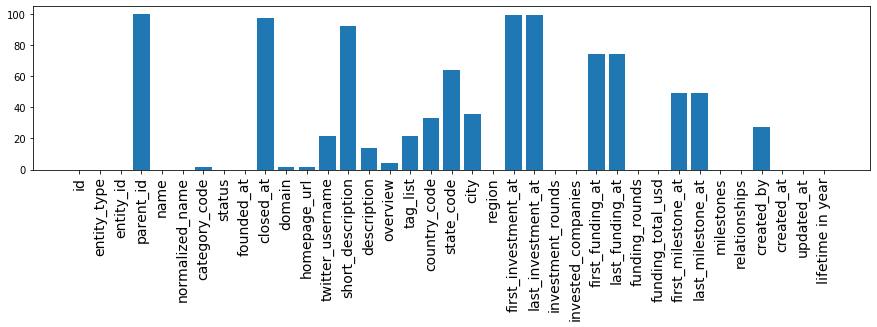

In [56]:
startup_missing = 100*startup.isna().sum()/startup.shape[0]
plt.figure(figsize=(15,3))
plt.bar(startup_missing.index,startup_missing)
plt.xticks(rotation=90,fontsize=14)
plt.show()

It definitely helps to reduce missing data on category_code

> We want to define successful startups as a startup which has been through an IPO or was acquired (possibly making reference to existing literature for this definition). Unicorns would also be a factor of success. How can we identify them ?

1. Use wikipedia data and make a search based on the name we see

In [57]:
# get wikipedia data
# current unicorns companies from Wikipedia
current_unicorns = pd.read_html('https://en.wikipedia.org/wiki/List_of_unicorn_startup_companies')[3]

# past unicorns companies from Wikipedia
past_unicorns = pd.read_html('https://en.wikipedia.org/wiki/List_of_unicorn_startup_companies')[4]

# create startup flag on wikipedia date
current_unicorns['current_unicorn']=1
past_unicorns['past_unicorn']=1

# normalize the names
# first simple strategy is to remove all capitalized letters
current_unicorns['Company_lower'] = current_unicorns['Company'].str.lower()
past_unicorns['Company_lower'] = past_unicorns['Company'].str.lower()
# set index as the company_lower names
current_unicorns.set_index('Company_lower',inplace=True)
past_unicorns.set_index('Company_lower',inplace=True)

In [58]:
# try a first merge

startup = pd.merge(left=startup,right=current_unicorns['current_unicorn'],left_on='normalized_name',right_index=True,how='left')
startup = pd.merge(left=startup,right=past_unicorns['past_unicorn'],left_on='normalized_name',right_index=True,how='left')
startup['is_unicorn'] = startup[['current_unicorn','past_unicorn']].apply(lambda row: 1 if ((row['current_unicorn']==1) or (row['past_unicorn']==1)) else 0,axis=1)
startup.groupby(['status','is_unicorn'], dropna=False)['id'].count()

status     is_unicorn
acquired   0              1073
           1                 1
closed     0              1131
ipo        0                32
           1                 2
operating  0             51732
           1               138
Name: id, dtype: int64

> With a simple exact match-up on the name, we have now identified 141 unicorns which in most cases are still operating as of 2013. So we will have 3 separated categories for successful startups: Unicorn, IPO and Acquired.

We want to create a successful flag which is 1 for success (acquired, IPO or Unicorn), and 0 otherwise. We convert to the categorical type

In [59]:
startup['sucessfull'] = startup[['status','is_unicorn']].apply(lambda row: 1 if ((row['is_unicorn']==1) 
or ((row['status']=='acquired') or (row['status'])=='ipo')) else 0,axis=1 )
startup['sucessfull'] = pd.Categorical(startup['sucessfull'])
startup['status'] = pd.Categorical(startup['status'])

> The startup file should be our main base file for all analysis and hence we will export it

### Does Industry Affect Success?

Let's first check the amount of missing data for category_code

In [60]:
startup[startup['category_code'].isna()].groupby(['sucessfull'])['id'].count()

sucessfull
0    936
1     62
Name: id, dtype: int64

This missing data represents a small percentage of our startup file especially for successful ones. We could try to infer the category_code from the short description but it will probably be difficult and unlikely to impact our analysis.

In [61]:
# Create a mutual information dictionnary which will keep track of all the scores
mi_overall = {}
max_mi_overall = {}

Let's visualize the industry of the startups

In [62]:
# create a function to vizualise distributions

def plot_distribution(df,feature,figsize=(12,6),top10_feature=False):
    # drop na for the feature
    df = df[~df[feature].isna()].copy()
    
    # count success for each value of feature
    feat_success = df.groupby([feature,'sucessfull'])['id'].count()
 

    # if top10_feature true returns only top 10 for success, and sort in descending order
    # of sucessfull
    if top10_feature:
        feat_success = feat_success.reset_index().sort_values(by=['sucessfull','id'],ascending=False)
        top = feat_success[feature].iloc[:10].to_list()
        # create other category
        top.append('other')
        no_success_other = feat_success[(~feat_success[feature].isin(top)) & 
        (feat_success['sucessfull']==0)]['id'].sum()
        success_other = feat_success[(~feat_success[feature].isin(top)) & 
        (feat_success['sucessfull']==1)]['id'].sum()
        feat_success = pd.concat([feat_success,pd.DataFrame({feature:'other','sucessfull':0,
        'id':no_success_other},index=[0])],ignore_index=True)
        feat_success = pd.concat([feat_success,pd.DataFrame({feature:'other','sucessfull':1,
        'id':success_other},index=[0])],ignore_index=True)
    else:
        feat_success = feat_success.reset_index()
        top = feat_success[feature].unique()
    
    no_success = feat_success[(feat_success['sucessfull']==0) & (feat_success[feature].isin(top))].copy()
    no_success = 100*no_success['id']/no_success['id'].sum()
    success = feat_success[(feat_success['sucessfull']==1) & (feat_success[feature].isin(top))].copy()
    success = 100*success['id']/success['id'].sum()
    labels = top

    
    # Compute mutual information for the feature
    mi = mutual_info_classif(pd.Categorical(df[feature]).codes.reshape(-1,1),df['sucessfull'],discrete_features=True)
    mi = round(mi[0],3)
    mi_overall[feature] = mi
    
    # compute max_mi
    p_success = feat_success[feat_success['sucessfull']==1]['id'].sum()/feat_success['id'].sum()
    max_mi = round(scipy.stats.entropy([p_success,1-p_success]),3)
    max_mi_overall[feature] = max_mi
    
    # plot
    fig = go.Figure(data=[
        go.Bar(name='Successful',
               x=labels, 
               y=success,
               text=round(success,1),
               marker=dict(color = '#FFCD09'),
    ),
        go.Bar(name='Unsuccessful',
               x=labels, 
               y=no_success,
               text=round(no_success,1),
               marker=dict(color = '#002147'),
      )
    ])

    fig.update_traces(marker_line_color='rgb(8,48,107)',
                      marker_line_width=2
    )

    fig.update_layout(barmode='group',
                      xaxis_title="", 
                      yaxis_title="Percent of Successful vs. Unsuccessful",
                      title=f'{feature} <br><sup>Mutual Information score of {mi} out of {max_mi} potential max</sup>',
                      xaxis=dict(showgrid=False),
                      yaxis=dict(showgrid=False), 
                      plot_bgcolor='rgba(0,0,0,0)'
    )

    fig.show()

In [63]:
plot_distribution(startup,'category_code',figsize=(18,6))

What is striking is that a lot of activities are ICT related: web, e-commerce, games video, messaging, mobile....

Some differences are significant, suggesting that the industry might play a role. Let's perform a Chi-square test

In [64]:
# contingency table
ctgcy = pd.crosstab(startup['sucessfull'],startup['category_code'])
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ctgcy)
if p<=0.05:
    print('Reject assumption of independence')
    print('p =',  p)

Reject assumption of independence
p = 7.821183681727909e-32


The industry category is not independent of the success, however, the mutual information score is quite low.

### Does Country Affect Success?

In [65]:
# first thing impact of missing countries
print(startup[startup['country_code'].isna()].groupby('sucessfull')['id'].count())

sucessfull
0    17664
1      179
Name: id, dtype: int64


Ok it is not negligible. Let's see if we find meaningful relations. If we can, we can try to infer the missing data.

In [66]:
plot_distribution(startup,'country_code',top10_feature=True)

In [67]:
# The dataset is probably biased towards the USA. Overall what is the percentage of US startups ?
(startup.groupby('country_code')['id'].count()/startup.shape[0]).sort_values(ascending=False)

country_code
USA    0.362768
GBR    0.054501
IND    0.037055
CAN    0.027241
DEU    0.016596
         ...   
SLE    0.000018
NRU    0.000018
SOM    0.000018
SUR    0.000018
SMR    0.000018
Name: id, Length: 149, dtype: float64

Only 36% of startups are in the US. So it's probably not that biased.

There is a strong concentration in the US. Let's look at the repartition across the United States

In [68]:
plot_distribution(startup,'state_code',top10_feature=True)

In [69]:
# Let's see this visualized on a map
startup_states = startup[(startup['country_code']=='USA') & (~startup['state_code'].isna())].copy()
startup_states = startup_states.groupby(['state_code','sucessfull'])['id'].count()

startup_states = startup_states.reset_index().pivot(columns='sucessfull',values='id',index='state_code')
startup_states[0] = 100*startup_states[0]/startup_states[0].sum()
startup_states[1] = 100*startup_states[1]/startup_states[1].sum()

In [70]:
fig = go.Figure(data=go.Choropleth(
    locations=startup_states.index, # spatial coordinates
    z = startup_states[1].astype(int), # data to be color-coded
    locationmode = 'USA-states', # set of locations that match entries in `locations`
    colorscale = ['white','#FFCD09'],
    colorbar_title = "percentage",
))

fig.update_layout(
    title_text = 'US Successful Startups by State',
    geo_scope='usa', # limit the map scope to USA
)

fig.show()

In [71]:
fig = go.Figure(data=go.Choropleth(
    locations=startup_states.index, # spatial coordinates
    z = startup_states[0].astype(int), # data to be color-coded
    locationmode = 'USA-states', # set of locations that match entries in `locations`
    colorscale = ['white','#002147'],
    colorbar_title = "percentage",
))

fig.update_layout(
    title_text = 'US Unsuccessful Startups by State',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

### Information and Communication Technologies Characteristics?

In [72]:
# Our assumption is that ICT infrastructures for a country might matter for startup to be sucessful
# Given the importance of some ICT related industries
# First retrieve ICT codes and definition from WDI data

ict_series_codes = ['IT.CEL.SETS.P2','IT.MLT.MAIN.P2','IT.NET.USER.ZS']

wdi_series = df_dict_wdi['data']
ict_series_def = wdi_series[wdi_series['Indicator Code'].isin(ict_series_codes)][['Indicator Code'
,'Indicator Name']]
ict_series_def = ict_series_def.groupby('Indicator Code').first()

#IT.CEL.SETS.P2- Mobile cellular subscriptions (per 100 people)
#IT.MLT.MAIN.P2- Fixed telephone subscriptions (per 100 people)
#IT.NET.USER.ZS- Individuals using the Internet (% of population)

In [73]:
# What are our top countries for startups
startup_by_ctry = startup.groupby('country_code')['id'].count()
startup_by_ctry.describe()

count      149.000000
mean       243.395973
std       1633.534986
min          1.000000
25%          2.000000
50%         13.000000
75%         78.000000
max      19629.000000
Name: id, dtype: float64

In [74]:
# We will focus on the countries which have at least 14 startups
startup_ctries_14 = startup_by_ctry[startup_by_ctry>=14].index

In [75]:
# quick quality check
ctry_check = startup[startup['country_code'].isin(startup_ctries_14)]
ctry_check = ctry_check.groupby('country_code').apply(lambda x: x['city'].unique())
# retrieve wdi ctries
wdi_ctries = df_dict_wdi['country']
wdi_ctries = wdi_ctries[wdi_ctries['Country Code'].isin(startup_ctries_14)]

# merge for check
ctry_check = pd.merge(left=ctry_check.reset_index(),right=wdi_ctries[['Short Name','Country Code']],
how='left',left_on='country_code',right_on='Country Code')

In [76]:
ctry_check.head(25)

country_code                                                  0  \
0           ARE  [Dubai, Deira, Dubai, nan, Dubayy, Sharjah, Aj...   
1           ARG  [CÃ³rdoba, Buenos Aires, Capital Federal, Mar ...   
2           AUS  [Abbotsford, Adelaide, nan, Sydney, South Melb...   
3           AUT  [Vienna, nan, Innsbruck, Linz, Perg, Graz, Hai...   
4           BEL  [Ghent, nan, Antwerp, Brussels, Louvain-la-Neu...   
5           BGD  [Dhaka, JESSORE, Chittagong, DHaka, gazipur, d...   
6           BGR  [Sofia, nan, Shumen, Sofiq, Plovdiv, Sofia,Bul...   
7           BLR                              [Minsk, Mogilev, nan]   
8           BRA  [Salvador, BrasÃ­lia, Belo Horizonte, Rio de J...   
9           CAN  [Quebec City, Toronto, Ingersoll, Vancouver, W...   
10          CHE  [Euthal, Geneva, Zurich, Basel, Zürich, Osterm...   
11          CHL  [Temuco, Santiago, Valparaíso, Providencia, Sa...   
12          CHN  [Shanghai, nan, Beijing, Hong Kong, Nanjing, B...   
13          COL  [Bogota, nan, Bogotá D.C., Bogotá, Medellin, B...   
14          CRI  [Heredia, Cartago, Alajuela, Mora, SJ, San Jos...   
15          CSS    [Belgrade, Nis, Novi Sad, Nova Pazova, Beograd]   
16          CYP  [Nicosia, Limassol, Paphos, Engomi, Nicosia, L...   
17          CZE  [Prague, Praha, Brno, Usti nad Labem, Prague 2...   
18          DEU  [Munich, Berlin, Norderstedt, Bonn, Oberhauase...   
19          DNK  [Copenhagen, Copenhagen O, Valby, Copenhagen N...   
20          EGY  [Cairo, Alexandria, New Cairo, nan, Giza, Nasr...   
21          ESP  [Madrid, Barcelona, St. Joan de Vilatorrada, V...   
22          EST  [Tartu, Tallin, Laagri, Tartumaa, tallinn, Tal...   
23          FIN  [JyvÃ¤skylÃ¤, Oulu, Espoo, Helsinki, HELSINKI,...   
24          FRA  [Paris, Saint Germain au Mont d'Or, PARIS, Ren...   

                Short Name Country Code  
0     United Arab Emirates          ARE  
1                Argentina          ARG  
2                Australia          AUS  
3                  Austria          AUT  
4                  Belgium          BEL  
5               Bangladesh          BGD  
6                 Bulgaria          BGR  
7                  Belarus          BLR  
8                   Brazil          BRA  
9                   Canada          CAN  
10             Switzerland          CHE  
11                   Chile          CHL  
12                   China          CHN  
13                Colombia          COL  
14              Costa Rica          CRI  
15  Caribbean small states          CSS  
16                  Cyprus          CYP  
17          Czech Republic          CZE  
18                 Germany          DEU  
19                 Denmark          DNK  
20                   Egypt          EGY  
21                   Spain          ESP  
22                 Estonia          EST  
23                 Finland          FIN  
24                  France          FRA

This quick manual check above shows issues between wdi and crunchbase ctry mapping for the following codes in crunchbase:

CSS (Serbia), ROM (Romania).

In [77]:
# let's correct the mapping of crunchbase so it can match wdi
crunch_to_wdi = {'CSS':'SRB','ROM':'ROU'}
startup_ctries_14_wdi = [code if ((code!='CSS') and (code!='ROM')) 
else crunch_to_wdi[code] for code in startup_ctries_14 ]
# let's get data from wdi
ict_series = wdi_series[(wdi_series['Indicator Code'].isin(ict_series_codes)) & 
(wdi_series['Country Code'].isin(startup_ctries_14_wdi))].copy()
ict_series.drop(['Country Name','Indicator Name'],axis=1,inplace=True)

In [78]:
# format ict series
ict_series = ict_series.melt(id_vars=['Country Code', 'Indicator Code'], var_name='Year')

# define a function which computes the mean of ICT indicator over 2000-2007
def ict_cat(group):
    group = group.set_index('Year').pivot(columns='Indicator Code',values='value')
    group = group.loc['2000':'2007',:].mean()
    return group
# apply this function to ict series grouped by country
ict_series = ict_series.groupby('Country Code').apply(ict_cat)

In [79]:
# For each ICT indicator discretize the ICT socre in 4 buckets corresponding to the 4 quartiles
for col in ict_series.columns:
    ict_series[col] = pd.qcut(ict_series[col],4,duplicates='drop')
    # convert to string for plotly
    ict_series[col] = ict_series[col].astype(str)

In [80]:
# Merge with startup
startup_ict = startup.merge(ict_series,how='left',left_on='country_code',right_index=True)
# Rename the code with their definition
startup_ict = startup_ict.rename(columns=ict_series_def.to_dict()['Indicator Name'])

In [81]:
for ict_indicator in ict_series_def.to_dict()['Indicator Name'].values():
    plot_distribution(startup_ict,ict_indicator)

### Is there a Network Effect across Startups?

We want to visualize the startups as a network. The first question is how do we define a link between two startups ?

We will define a link between two startups if they have at least one investor in common. However, we need to check if some successful startups got new investors after being successful. If this is the case, it could be problematic when trying to identify the future successful startups.

In [82]:
# first let's check if some companies receive funding once successful

# we need the date of acquisition
acq = df_dict['acquisitions']
startup = startup.merge(acq[['acquired_at','acquired_object_id']],how='left',left_on='id',right_on='acquired_object_id')
startup['acquired_at'] = pd.to_datetime(startup['acquired_at'])
# we need date of IPO
ipo = df_dict['ipos']
startup = startup.merge(ipo[['public_at','object_id']],how='left',left_on='id',right_on='object_id')
startup['public_at'] = pd.to_datetime(startup['public_at'])

In [83]:
# let's check for acquired and ipos
startup['funding_after_success'] = startup[['last_funding_at',
'acquired_at','public_at']].apply(lambda x: 1 if (x['last_funding_at']-x['acquired_at']).days>0 
or (x['last_funding_at']-x['public_at']).days>0 else 0,axis=1)

In [84]:
startup['funding_after_success'].sum()

31

31 successful companies (IPO or acquired) got their last funding after being sucessful

This is not material. Unfortunately for unicorns we are not able to find the data at which their valuation reached the USD1bn threshold. Wikipedia which was our source to identify unicorns does not have this information. Moreover, we can't retrieve valuation information from Yahoo Finance at some of the unicorns are not public (or were not public when they became unicorns).

We will keep track of where are unicorns in our network.

#### Sharing some investors

We first need to create an adjacency matrix from the investments.csv file

In [85]:
# retrieve investments.csv
investments = df_dict['investments']
# filter on the startup
investments = investments[investments['funded_object_id'].isin(startup['id'].unique())].copy()

In [86]:
# count the occurence of each investors (column) for each startup (row)
cross = pd.crosstab(investments['funded_object_id'],investments['investor_object_id'])
# we replace by one as we don't care if an investor has funded the same startup more than once
cross = cross.applymap(lambda x: 1 if x>0 else 0)

# instantiate undirected, unweighted graph
G = nx.Graph()

# add nodes to the graph
G.add_nodes_from(startup['id'])

# add attribute
nx.set_node_attributes(G,startup.set_index('id')['sucessfull'].to_dict(),'Sucess')
nx.set_node_attributes(G,startup.set_index('id')['funding_after_success'].to_dict(),'fdg_aftr')
nx.set_node_attributes(G,startup.set_index('id')['status'].to_dict(),'status')
nx.set_node_attributes(G,startup.set_index('id')['is_unicorn'].to_dict(),'unicorn')
# add edges to the graph

# check the investors for which are present in more than one startup
inv_more_1 = cross.sum()
inv_more_1 = inv_more_1[inv_more_1>1]
inv_more_1 = inv_more_1.index

for investor in inv_more_1:
    # retrieve the startups for this investor
    connected_startups = cross[investor]
    connected_startups = connected_startups[connected_startups!=0]
    # we need to draw an edge between every pair of startup who share this investor
    edges = list(itertools.combinations(connected_startups.index,2))
    G.add_edges_from([edge for edge in edges if edge not in G.edges])

In [87]:
# How many connected graphs do we have ?
nx.number_connected_components(G)

47262

In [88]:
# describe size of connected_components
connected_comp = [len(comp) for comp in list(nx.connected_components(G))]
connected_comp = pd.Series(connected_comp)
connected_comp.describe()

count    47262.000000
mean         1.144873
std         30.235089
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       6574.000000
dtype: float64

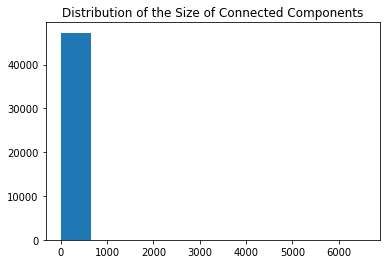

In [89]:
plt.hist(connected_comp)
plt.title('Distribution of the Size of Connected Components')
plt.show()

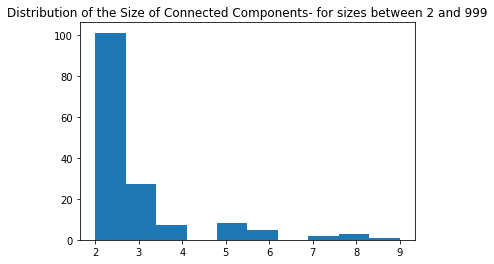

In [90]:
plt.hist(connected_comp[(connected_comp>1) & (connected_comp<1000)])
plt.title('Distribution of the Size of Connected Components- for sizes between 2 and 999')
plt.show()

Most of the startups are not connected by sharing one or more investors. Only  a small number form networks, out of which there is a very large network of 6574 startups. The other networks are very small.

Now the question is where are the successful startups ?

In [91]:
# generate subgraph for each connected component
graph_list = [G.subgraph(c).copy() for c in nx.connected_components(G)]
# count number of sucessfull companies in each subgraph
success_count = [sum(nx.get_node_attributes(sub_g,'Sucess').values()) for sub_g in graph_list]
success_count = pd.Series(success_count)
# count number of post success founding
fdgpost_count = [sum(nx.get_node_attributes(sub_g,'fdg_aftr').values()) for sub_g in graph_list]
fdgpost_count = pd.Series(fdgpost_count)
# count number of unicorn
unicorn_count = [sum(nx.get_node_attributes(sub_g,'unicorn').values()) for sub_g in graph_list]
unicorn_count = pd.Series(unicorn_count)
size_subgraph = [len(sub_g) for sub_g in graph_list]


# merge
df_subgraph = pd.DataFrame({'Number nodes':size_subgraph,'Number sucess':success_count,
'Number fdg post success': fdgpost_count,'Number unicorns':unicorn_count})

In [92]:
df_subgraph[df_subgraph['Number sucess']>1]

Number nodes  Number sucess  Number fdg post success  Number unicorns
9              6574            539                       16               95
17167             2              2                        0                0

That is interesting. We can see that out of 1246 successful startups, 539 are in a big network of 6574 startups.

In [93]:
# How many startups in percentage are there in the biggest network ?
6574/df_subgraph['Number nodes'].sum()

0.12149549982442846

In [94]:
# How many successful startups are in the percentage in the biggest network ?
539/df_subgraph['Number sucess'].sum()

0.43258426966292135

Let's look at the network

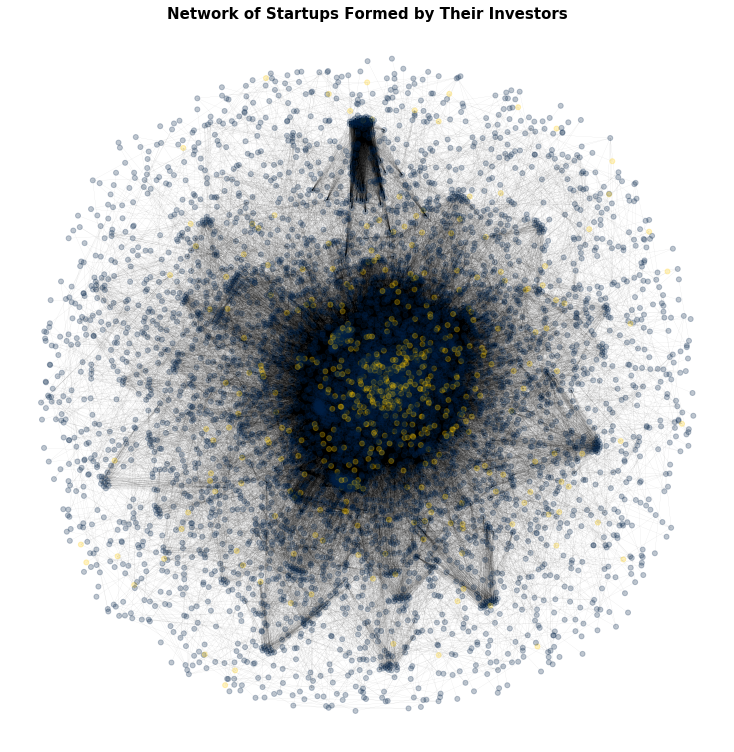

In [95]:
plt.figure(figsize=(10,10))
sub_g_max = graph_list[np.argmax(size_subgraph)]
nx.get_node_attributes(sub_g_max,'Sucess')
no_success_nodes = [node[0] for node in nx.get_node_attributes(sub_g_max,'Sucess').items() if node[1]==0]
success_nodes = [node[0] for node in nx.get_node_attributes(sub_g_max,'Sucess').items() if node[1]==1]
unicorn_nodes = [node[0] for node in nx.get_node_attributes(sub_g_max,'unicorn').items() if node[1]==1]
pos = nx.spring_layout(sub_g_max,k=0.2,seed=42)
nx.draw(sub_g_max,
node_color=['#002147' if node in no_success_nodes else '#FFCD09' for node in sub_g_max.nodes],
node_size=25,pos=pos,alpha=0.25,width=0.1)
plt.title('Network of Startups Formed by Their Investors',fontdict={'fontsize': 15,'fontweight':'bold'})
plt.show()

What we can see in the network above is that most of the yellow successful startups are concentrated in the center. For the blue unsuccessful startups, we do see some clusters as well, but overall more dispersion. The layout is chosen to display the network as a spring layout. This layout tries to display each startup as far as possible from each other, but if they are connected, the connection acts like a spring and bring them back closer from each other. The display therefore suggests that successful startups tend to have more connexions than unsuccessful one. Let's confirm below

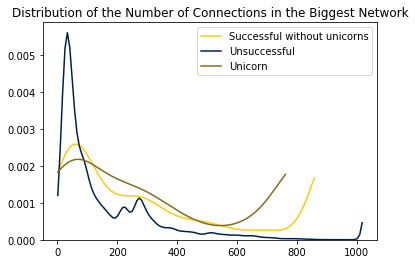

In [96]:
# plot the distribution of the number of connexions
degree_sucess = [item[1] for item in dict(sub_g_max.degree).items() if ((item[0] in success_nodes) and (item[0] not in unicorn_nodes))]
degree_no_sucess = [item[1] for item in dict(sub_g_max.degree).items() if item[0] in no_success_nodes]
degree_unicorn = [item[1] for item in dict(sub_g_max.degree).items() if item[0] in unicorn_nodes]

sns.kdeplot(degree_sucess,label='Successful without unicorns',cut=0,color='#FFCD09')
sns.kdeplot(degree_no_sucess,label='Unsuccessful',cut=0,color = '#002147')
sns.kdeplot(degree_unicorn,label='Unicorn',cut=0, color='#806c20')
plt.title('Distribution of the Number of Connections in the Biggest Network')
plt.legend()
plt.show()

Clearly, if we observe the main network of a high number of connections, the probability that it is a successful startup is much higher.

In [97]:
# sns.kdeplot(degree_no_sucess, bw=1)
print(degree_no_sucess[:10])

[118, 42, 45, 26, 132, 68, 248, 110, 57, 45]


RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

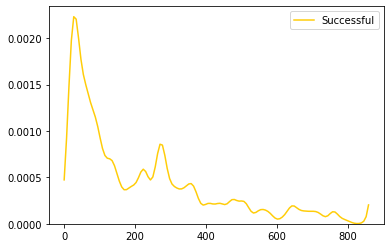

In [98]:
# distribution of connexions overall accross all graph

degree_sucess = []
degree_no_sucess = []

# loop through graphs
for graph in graph_list:
    # retrieve success nodes
    no_success_nodes = [node[0] for node in nx.get_node_attributes(graph,'Sucess').items() if node[1]==0]
    success_nodes = [node[0] for node in nx.get_node_attributes(graph,'Sucess').items() if node[1]==1]
    # retrieve number of degree
    degree_sucess.extend([item[1] for item in dict(graph.degree).items() if item[0] in success_nodes])
    degree_no_sucess.extend([item[1] for item in dict(graph.degree).items() if item[0] in no_success_nodes])

sns.kdeplot(degree_sucess,label='Successful',cut=0,color='#FFCD09')
sns.kdeplot(degree_no_sucess,label='Unsuccessful',cut=0,color='#002147')
plt.title('Distribution of the Number of Connections Overall')
plt.legend()
plt.show()

In [ ]:
success = [1 for node in degree_sucess]
success.extend([0 for node in degree_no_sucess])
degree_sucess.extend(degree_no_sucess)

degree_suc = pd.DataFrame({'Success':success,'Degree':degree_sucess})

In [ ]:
# compute mutual information for this feature
mi_network = mutual_info_classif(degree_suc['Degree'].to_numpy().reshape(-1,1),degree_suc['Success'],discrete_features=True)
# compute max mutual information for this feature
p_success = degree_suc[degree_suc['Success']==1].shape[0]/degree_suc.shape[0]
max_mi_network = round(scipy.stats.entropy([p_success,1-p_success]),3)

In [ ]:
mi_overall['Network Investors'] = mi_network[0]
max_mi_overall['Network Investors'] = max_mi_network

In [ ]:
mi_overall

This so far the most informative feature we can find to differentiate between sucessful and unsucessful startups.

However, we should keep in mind that for unicorns most of them are in the big network and have a high number of connections. If we could verify that for non-unicorn, very little successful startups receive funding after success, we can not check this for unicorns.

### Does Company Size Affect Success?

Maybe the size of the company goes on to affect how successful it becomes

In [ ]:
#Let's get these specified down to the amount people per company 
ppl_degree = df_1[['name', 'sucessfull', 'person_object_id']]
unique_ppl_degree=ppl_degree.drop_duplicates()
count_unique_ppl = unique_ppl_degree.groupby('name').agg(sucessfull = ('sucessfull', 'first'), people = ('person_object_id', 'count'))
count_unique_ppl.head()

In [ ]:
# Exploring the amount of people per company in our startups- checking successful and unsuccessful

co_type_successful = count_unique_ppl[count_unique_ppl['sucessfull'] == 1]
co_type_successful = pd.DataFrame(co_type_successful.groupby('people').count()) \
                           .rename(columns={'sucessfull':'count_successful'}) \
                           .reset_index()


co_type_unsuccessful = count_unique_ppl[count_unique_ppl['sucessfull'] == 0]
co_type_unsuccessful = pd.DataFrame(co_type_unsuccessful.groupby('people').count()) \
                             .rename(columns={'sucessfull':'count_unsuccessful'}) \
                             .reset_index()

people = co_type_successful.merge(co_type_unsuccessful, left_on='people', right_on='people', how='outer')
people['successful_percent'] = round(people['count_successful']/people['count_successful'].sum()*100, 1)
people['unsuccessful_percent'] = round(people['count_unsuccessful']/people['count_unsuccessful'].sum()*100, 1)
people = people.sort_values(by=['successful_percent', 'unsuccessful_percent'],ascending=False)
people['bucket'] = pd.qcut(people['people'],10)

In [ ]:
# Let's make sure were able to sum up the successful and unsuccessful percent's of companies
people = people.groupby(['bucket'])[['successful_percent', 'unsuccessful_percent']].sum().reset_index()

In [ ]:
# map count_unique_ppl to the created intervals
intervals = people['bucket'].unique()
interval_array = pd.arrays.IntervalArray(intervals)

count_unique_ppl['bucket'] = count_unique_ppl['people'].apply(lambda x: str(intervals[interval_array.contains(x)][0]))

# Compute mutual information for the feature
mi = mutual_info_classif(pd.Categorical(count_unique_ppl['bucket']).codes.reshape(-1,1),count_unique_ppl['sucessfull'],discrete_features=True)
mi = round(mi[0],3)
    
# compute max_mi
p_success = count_unique_ppl[count_unique_ppl['sucessfull']==1]['people'].count()/count_unique_ppl.shape[0]
max_mi = round(scipy.stats.entropy([p_success,1-p_success]),3)

mi_overall['Size Company'] = mi
max_mi_overall['Size Company'] = max_mi

In [ ]:
# Also have to ensure it's the right data type to plot 
people['bucket'] = people['bucket'].astype(str)

In [ ]:
# Plotting our companies

fig = go.Figure(data=[
    go.Bar(name='Successful',
           x=people['bucket'], 
           y=people['successful_percent'],
           text=people['successful_percent'],
           marker=dict(color = '#FFCD09'),
),
    go.Bar(name='Unsuccessful',
           x=people['bucket'], 
           y=people['unsuccessful_percent'],
           text=people['unsuccessful_percent'],
           marker=dict(color = '#002147'),
  )
])

fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=2
)

fig.update_layout(barmode='group',
                  xaxis_title="Amount of Employees", 
                  yaxis_title="Percent of Successful vs. Unsuccessful",
                  title=f'Company Size Affect on Success<br><sup>Mutual Information score of {mi} out of {max_mi} potential max</sup>',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False), 
                  plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

It appears that company size does have an affect on success. It appears that more often than not successful startups are more likely to have more employees than unsuccessful startups

### Do Macro Factors (GDP, Int Rates, Education of Labor Force) Affect Success?

In [ ]:
# Our assumption is that macro factors for a country might matter for startup to be sucessful
# First retrieve macro factor codes and definition from WDI data

ict_series_codes = ['SL.TLF.BASC.ZS','NY.GDP.PCAP.CD','FR.INR.RINR']

wdi_series = df_dict_wdi['data']
ict_series_def = wdi_series[wdi_series['Indicator Code'].isin(ict_series_codes)][['Indicator Code'
,'Indicator Name']]
ict_series_def = ict_series_def.groupby('Indicator Code').first()

# FR.INR.RINR- real int rates %
# NY.GDP.PCAP.CD- GDP per capita (current US$)
# SL.TLF.BASC.ZS- Labor force with basic education (% of total working-age population with basic education)

In [ ]:
wdi_series.head()

In [ ]:
# What are our top countries for startups
startup_by_ctry = startup.groupby('country_code')['id'].count()
startup_by_ctry.describe()

In [ ]:
# We will focus on the countries which have at least 14 startups
startup_ctries_14 = startup_by_ctry[startup_by_ctry>=14].index

In [ ]:
# quick quality check
ctry_check = startup[startup['country_code'].isin(startup_ctries_14)]
ctry_check = ctry_check.groupby('country_code').apply(lambda x: x['city'].unique())
# retrieve wdi ctries
wdi_ctries = df_dict_wdi['country']
wdi_ctries = wdi_ctries[wdi_ctries['Country Code'].isin(startup_ctries_14)]

# merge for check
ctry_check = pd.merge(left=ctry_check.reset_index(),right=wdi_ctries[['Short Name','Country Code']],
how='left',left_on='country_code',right_on='Country Code')

In [ ]:
# let's correct the mapping of crunchbase so it can match wdi
crunch_to_wdi = {'CSS':'SRB','ROM':'ROU'}
startup_ctries_14_wdi = [code if ((code!='CSS') and (code!='ROM')) 
else crunch_to_wdi[code] for code in startup_ctries_14 ]
# let's get data from wdi
ict_series = wdi_series[(wdi_series['Indicator Code'].isin(ict_series_codes)) & 
(wdi_series['Country Code'].isin(startup_ctries_14_wdi))].copy()
ict_series.drop(['Country Name','Indicator Name'],axis=1,inplace=True)

In [ ]:
# format macro factor series
ict_series = ict_series.melt(id_vars=['Country Code', 'Indicator Code'], var_name='Year')

# define a function which computes the mean of macro factors from 2000-2007
def ict_cat(group):
    group = group.set_index('Year').pivot(columns='Indicator Code',values='value')
    group = group.loc['2000':'2007',:].mean()
    return group
# apply this function to macro factors grouped by country
ict_series = ict_series.groupby('Country Code').apply(ict_cat)

In [ ]:
# for each macro factor discretize the factors across 4 buckets corresponding to the 4 quartiles
for col in ict_series.columns:
    ict_series[col] = pd.qcut(ict_series[col],4,duplicates='drop')
    # convert to string for plotly
    ict_series[col] = ict_series[col].astype(str)

In [ ]:
# merge with startup
startup_ict = startup.merge(ict_series,how='left',left_on='country_code',right_index=True)
# rename the code with their definition
startup_ict = startup_ict.rename(columns=ict_series_def.to_dict()['Indicator Name'])

In [ ]:
for ict_indicator in ict_series_def.to_dict()['Indicator Name'].values():
    plot_distribution(startup_ict,ict_indicator)

### Do Workforce Demographics Affect Success?


#### Degrees

In [ ]:
# Exploring the degree types in our startups

degree_type_successful = degrees[degrees['sucessfull'] == 1]
degree_type_successful = pd.DataFrame(degree_type_successful.groupby(['degree_type'])['degree_type'].count()) \
                           .rename(columns={'degree_type':'count_successful'}) \
                           .reset_index() \
                           .sort_values('count_successful', ascending=False) \
                           .reset_index(drop=True) \
                           .head() # limiting to the top ten most popular degrees

degree_type_unsuccessful = degrees[degrees['sucessfull'] == 0]
degree_type_unsuccessful = pd.DataFrame(degree_type_unsuccessful.groupby(['degree_type'])['degree_type'].count()) \
                             .rename(columns={'degree_type':'count_unsuccessful'}) \
                             .reset_index()

degree_type = degree_type_successful.merge(degree_type_unsuccessful, left_on='degree_type', right_on='degree_type', how='left')
degree_type['successful_percent'] = round(degree_type['count_successful']/degree_type['count_successful'].sum()*100, 1)
degree_type['unsuccessful_percent'] = round(degree_type['count_unsuccessful']/degree_type['count_unsuccessful'].sum()*100, 1)
degree_type = degree_type.sort_values(by=['successful_percent', 'unsuccessful_percent'],ascending=False)

In [ ]:
# Compute MI for number of diploma accross the top ten most popular degrees
# first get number of various degree type for each companies
degre_success = degrees.groupby(['name','degree_type'])['sucessfull'].agg(success='first',nber='count')

# loop throught the most popular degree type
mi_degree = {}
max_mi_degree={}
for degree in ['BS','BA','MBA','MS','PhD']:
    scope = degre_success.loc[(slice(None),degree),:].copy()
    mi = mutual_info_classif(scope['nber'].to_numpy().reshape(-1,1),scope['success'],discrete_features=True)
    mi = round(mi[0],3)
    mi_degree[degree] = mi
    mi_overall[degree] = mi

    p_success =scope[scope['success']==1]['nber'].count()/scope.shape[0]
    max_mi = round(scipy.stats.entropy([p_success,1-p_success]),3)
    max_mi_degree[degree] = max_mi
    max_mi_overall[degree] = max_mi


In [ ]:
# Plotting our degree types- checking successful and unsuccessful

fig = go.Figure(data=[
    go.Bar(name='Successful',
           x=degree_type['degree_type'], 
           y=degree_type['successful_percent'],
           text=degree_type['successful_percent'],
           marker=dict(color = '#FFCD09'),
),
    go.Bar(name='Unsuccessful',
           x=degree_type['degree_type'], 
           y=degree_type['unsuccessful_percent'],
           text=degree_type['unsuccessful_percent'],
           marker=dict(color = '#002147'),
  )
])

fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=2
)

fig.update_layout(barmode='group',
                  xaxis_title="", 
                  yaxis_title="Percent of Successful vs. Unsuccessful",
                  title=f'Percentage of Degree Types across Startups<br><sup>Average Mutual Information score for a given degree type of {np.mean(list(mi_degree.values()))} out of {np.mean(list(max_mi_degree.values()))} potential max average</sup>',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False), 
                  plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

### Do Quantitative Funding Factors Affect Success?

In [ ]:
# Exploring the funding rounds of our startups
# Preparing our Data to be Displayed

# funding_rounds = df_dict['startup'].merge(df_dict['funding_rounds'], left_on='id', right_on='object_id', how='inner') \
#                                    .rename(columns={'name_x': 'name', 'sucessfull_x':'successful'})
# funding_rounds_amounts = pd.DataFrame(funding_rounds[['raised_amount_usd','pre_money_valuation_usd']])
funding_rounds_amounts = pd.DataFrame(funding_rounds[['name', 'raised_amount_usd','pre_money_valuation_usd', 'post_money_valuation_usd', 'sucessfull']])
# funding_rounds_amounts = funding_rounds_amounts.rename(columns={'name_x':'name', 'sucessfull_x':'successful'})
funding_rounds_amounts_not_zero = funding_rounds_amounts[(funding_rounds_amounts['pre_money_valuation_usd'] > 0) &
                                                         (funding_rounds_amounts['raised_amount_usd'] < 150000000)]

In [ ]:
# Commented out for brevity
# Exploring the market caps of our startups 

# df_yahoo = pd.concat(results_main)
# df_yahoo_high = pd.DataFrame(df_yahoo.groupby(['startup'])['High'].max()) \
#                   .reset_index()

# df_yahoo_shares = pd.DataFrame(df_yahoo.groupby(['startup'])['Volume'].max()) \
#                     .reset_index()

# df_yahoo_market_cap = df_yahoo_high.merge(df_yahoo_shares, left_on='startup', right_on='startup')
# df_yahoo_market_cap['market_cap'] = round(df_yahoo_market_cap['High']*df_yahoo_market_cap['Volume'], 1)

# funding_comp_0 = ipos.merge(funding_rounds, left_on='id', right_on='id_x', how='left')
# funding_comp_1 = funding_comp_0.merge(df_yahoo_market_cap, left_on='stock_symbol', right_on='startup')
# funding_comp_2 = pd.DataFrame(funding_comp_1[['startup', 'market_cap', 'raised_amount_usd']] \
#                    .groupby(['startup'])['raised_amount_usd'].sum()) \
#                    .reset_index()

# funding_comp = funding_comp_1[['startup', 'market_cap', 'raised_amount_usd']]
# funding_comp = funding_comp.merge(funding_comp_2, left_on='startup', right_on='startup', how='left') \
#                            .drop(columns=['raised_amount_usd_x']) \
#                            .rename(columns={'raised_amount_usd_y': 'raised_amount_usd'}) \
#                            .drop_duplicates()

Nothing substantially conclusive came from reviewing firms' market capitalizations and pre-money valuations. 

In [ ]:
# Exploring the amounts raised of our startups

amounts_raised = pd.DataFrame(funding_rounds_amounts \
                   .groupby(['name', 'sucessfull'])['raised_amount_usd'] \
                   .sum()) \
                   .reset_index()

amounts_raised['group'] = np.where(amounts_raised['raised_amount_usd'] <= 5000000, '0-5M',
                          np.where((amounts_raised['raised_amount_usd'] > 5000000) & (amounts_raised['raised_amount_usd'] < 10000000), '5-10M',
                          np.where(amounts_raised['raised_amount_usd'] > 10000000, '10M+', 'Other')))

amounts_raised_successful = amounts_raised[amounts_raised['sucessfull']==1]
amounts_raised_successful = pd.DataFrame(amounts_raised_successful \
                              .groupby(['group'])['group'] \
                              .count()) \
                              .rename(columns={'group': 'count_successful'}) \
                              .reset_index()

amounts_raised_unsuccessful = amounts_raised[amounts_raised['sucessfull']==0]
amounts_raised_unsuccessful = pd.DataFrame(amounts_raised_unsuccessful \
                                .groupby(['group'])['group'] \
                                .count()) \
                                .rename(columns={'group': 'count_unsuccessful'}) \
                                .reset_index()

amounts_raised = amounts_raised_successful.merge(amounts_raised_unsuccessful, left_on='group', right_on='group', how='inner')
amounts_raised['successful_percent'] = round(amounts_raised['count_successful']/amounts_raised['count_successful'].sum()*100, 1)
amounts_raised['unsuccessful_percent'] = round(amounts_raised['count_unsuccessful']/amounts_raised['count_unsuccessful'].sum()*100, 1)
amounts_raised = amounts_raised.sort_values(by=['successful_percent', 'unsuccessful_percent'],ascending=False)

In [ ]:
# Commented out for brevity
# Exploring the funding rounds regardless of Successful categorization

# funding_rounds_amounts_fig = px.histogram(funding_rounds_amounts_not_zero, 
#                                           x="raised_amount_usd", 
#                                           nbins=10, 
#                                           width=800, 
#                                           height=400, 
#                                           title='Distribution of Amounts Raised in USD',
#                                           labels={'raised_amount_usd':'Amount Raised ($ USD)'})

# pre_money_valuation_fig = px.histogram(funding_rounds_amounts_not_zero, 
#                                        x="pre_money_valuation_usd", 
#                                        nbins=10, 
#                                        width=800, 
#                                        height=400, 
#                                        title='Distribution of Amounts Raised in USD',
#                                        labels={'pre_money_valuation_usd':'Pre-Money Valuation ($ USD)'})

# funding_pre_money_fig = px.scatter(funding_rounds_amounts_not_zero, 
#                                    x="raised_amount_usd", 
#                                    y="pre_money_valuation_usd",
#                                    width=800, 
#                                    height=400,
#                                    title='Comparing Raised Amounts with Pre-Money Valuations',
#                                    labels={'raised_amount_usd':'Amount Raised ($ USD)',
#                                            'pre_money_valuation_usd':'Pre-Money Valuation ($ USD)'},
#                                    color='raised_amount_usd',
#                                    trendline="ols",
#                                    color_continuous_scale=px.colors.sequential.Cividis_r)

# funding_rounds_amounts_fig.show()
# pre_money_valuation_fig.show()
# funding_pre_money_fig.show()

In [ ]:
# Plotting the distribution of our startup's raised amounts in USD

raised_amounts_hist = px.histogram(funding_rounds_amounts, 
                                   x="raised_amount_usd", 
                                   nbins=100, 
                                   width=800, 
                                   height=400, 
                                   title='Distribution of Amounts Raised in USD',
                                   labels={'raised_amount_usd':'Amount Raised ($ USD)'},
                                   color='sucessfull'
)

raised_amounts_hist

The distribution of amounts raised (between both successful and unsuccessful firms) is unipolar with a right skew - due to outliers north of 800M USD. The majority of firms raised between 0-10M USD.

In [ ]:
# Plotting Max Market Cap vs. Raised Amount

funding_comp = df_dict['funding_comp']

funding_comp_fig = px.scatter(funding_comp, 
                              x="market_cap", 
                              y="raised_amount_usd",
                              width=800, 
                              height=400,
                              title='Comparing Max Market Capitalization with Total Amount Raised',
                              labels={'raised_amount_usd':'Amount Raised ($ USD)',
                                      'market_cap':'Market Capitalization ($ USD)'},
                              color='raised_amount_usd',
                              trendline="ols",
                              color_continuous_scale=px.colors.sequential.Cividis_r)
funding_comp_fig.show()

The correlation between amount raised and market capitalization is statistically insignificant with a pearson correlation coefficient of .477 - meaning there is a positive (linear) relationship, but not a strong one. 

In [ ]:
# Compute MI for funding rounds amount
# first get the corresponding buckets
funding_rounds_amounts['group'] = np.where(funding_rounds_amounts['raised_amount_usd'] <= 5000000, '0-5M',
                          np.where((funding_rounds_amounts['raised_amount_usd'] > 5000000) & (funding_rounds_amounts['raised_amount_usd'] < 10000000), '5-10M',
                          np.where(funding_rounds_amounts['raised_amount_usd'] > 10000000, '10M+', 'Other')))

mi = mutual_info_classif(pd.Categorical(funding_rounds_amounts['group']).codes.reshape(-1,1),funding_rounds_amounts['sucessfull'],discrete_features=True)
mi = round(mi[0],3)
mi_overall['Amount Funding Raised'] = mi

p_success =funding_rounds_amounts[funding_rounds_amounts['sucessfull']==1]['group'].count()/funding_rounds_amounts.shape[0]
max_mi = round(scipy.stats.entropy([p_success,1-p_success]),3)
max_mi_overall['Amount Funding Raised'] = max_mi

In [ ]:
# Plotting Funding Rounds Percentages - grouped by Success Category

fig = go.Figure(data=[
    go.Bar(name='Successful',
           x=amounts_raised['group'], 
           y=amounts_raised['successful_percent'],
           text=amounts_raised['successful_percent'],
           marker=dict(color = '#FFCD09'),
),
    go.Bar(name='Unsuccessful',
           x=amounts_raised['group'], 
           y=amounts_raised['unsuccessful_percent'],
           text=amounts_raised['unsuccessful_percent'],
           marker=dict(color = '#002147'),
  )
])

fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=2
)

fig.update_layout(barmode='group',
                  xaxis_title="", 
                  yaxis_title="Percent of Successful vs. Unsuccessful",
                  title=f'Percentage of Startups Across Funding Amount Groups<br><sup>Mutual Information score of {mi} out of {max_mi} potential max</sup>',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False), 
                  plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

The majority of firms raised between 0-5M, while the second most frequent rate raised was 10M USD and more.

### Do Qualitative Funding Factors Affect Success?

In [ ]:
# Exploring the funding rounds of our startups
# Preparing our Data to be Displayed

funding_rounds_categories = pd.DataFrame(funding_rounds.groupby(['funding_round_type'])['id'].count()) \
                              .reset_index() \
                              .sort_values(by='id',ascending=True)

funding_rounds_successful = funding_rounds[funding_rounds['sucessfull']==1]
funding_rounds_unsuccessful = funding_rounds[funding_rounds['sucessfull']==0]

funding_rounds_successful = pd.DataFrame(funding_rounds_successful \
                              .groupby(['funding_round_type'])['id'] \
                              .count()) \
                              .reset_index() \
                              .rename(columns={'id':'count_successful'})

funding_rounds_unsuccessful = pd.DataFrame(funding_rounds_unsuccessful \
                                .groupby(['funding_round_type'])['id'].count()) \
                                .reset_index() \
                                .rename(columns={'id':'count_unsuccessful'})

funding_rounds_combined = funding_rounds_successful.merge(funding_rounds_unsuccessful, 
                                                          how='inner', 
                                                          left_on='funding_round_type', 
                                                          right_on='funding_round_type') \
                                                   .rename(columns={'id_x_x':'count_successful',
                                                                    'id_x_y':'count_unsuccessful'})

# Grouping our data by Funding Round
funding_rounds_combined['sum_total'] = funding_rounds_combined['count_successful']+funding_rounds_combined['count_unsuccessful']
funding_rounds_combined['percent_successful'] = round(funding_rounds_combined['count_successful']/funding_rounds_combined['sum_total']*100, 2)
funding_rounds_combined['percent_unsuccessful'] =  round(funding_rounds_combined['count_unsuccessful']/funding_rounds_combined['sum_total']*100, 2)
funding_rounds_combined = funding_rounds_combined.sort_values(by=['percent_successful', 'percent_unsuccessful'], ascending=True)

# Grouping our data by Success Category
funding_rounds_by_success_cat = funding_rounds_combined[['funding_round_type', 'count_successful', 'count_unsuccessful']]
funding_rounds_by_success_cat['successful_percent'] = round(funding_rounds_by_success_cat['count_successful']/funding_rounds_by_success_cat['count_successful'].sum()*100, 1)
funding_rounds_by_success_cat['unsuccessful_percent'] = round(funding_rounds_by_success_cat['count_unsuccessful']/funding_rounds_by_success_cat['count_unsuccessful'].sum()*100, 1)
funding_rounds_by_success_cat = funding_rounds_by_success_cat.sort_values(by=['successful_percent', 'unsuccessful_percent'],ascending=False)

In [ ]:
# Commented out as we decided to go a different direction - but this still provides a useful view so the code was kept in
# Plotting Funding Rounds Percentages - grouped by Funding Rounds

# colours = {
#     "percent_successful": "#FFCD09",
#     "percent_unsuccessful": "#002147",
# }

# funding_rounds_categories_fig = px.bar(funding_rounds_combined, 
#                                        x=['percent_successful', 'percent_unsuccessful'], 
#                                        y='funding_round_type', 
#                                        title='Funding Rounds Reached by Startups',
#                                        labels={'funding_round_type':'', 'value':'Percentage of Firms'}, 
#                                        text_auto='.2s',
#                                        color_discrete_map=colours
#                                  ).update_traces(
#                                        marker_line_color='rgb(8,48,107)',
#                                        marker_line_width=2
#                                  ).update_layout(
#                                        xaxis=dict(showgrid=False),
#                                        yaxis=dict(showgrid=False), 
#                                        plot_bgcolor='rgba(0,0,0,0)'
# )

# funding_rounds_categories_fig.show() 

In [ ]:
# Compute MI for number of funding_round_types
# first get number of various degree type for each companies
funding_success = funding_rounds.groupby(['id','funding_round_type'])['sucessfull'].agg(success='first', nber='count')

# loop throught the funding round types
mi_fdg = {}
max_mi_fdg={}
for fdg in funding_rounds['funding_round_type'].dropna().unique():
    scope = funding_success.loc[(slice(None),fdg),:].copy()
    mi = mutual_info_classif(scope['nber'].to_numpy().reshape(-1,1),scope['success'],discrete_features=True)
    mi = round(mi[0],3)
    mi_fdg[fdg] = mi
    mi_overall[fdg] = mi

    p_success =scope[scope['success']==1]['nber'].count()/scope.shape[0]
    max_mi = round(scipy.stats.entropy([p_success,1-p_success]),3)
    max_mi_fdg[fdg] = max_mi
    max_mi_overall[fdg] = max_mi

In [ ]:
# Plotting Funding Rounds Percentages - grouped by Success Category

fig = go.Figure(data=[
    go.Bar(name='Successful',
           x=funding_rounds_by_success_cat['funding_round_type'], 
           y=funding_rounds_by_success_cat['successful_percent'],
           text=funding_rounds_by_success_cat['successful_percent'],
           marker=dict(color = '#FFCD09'),
),
    go.Bar(name='Unsuccessful',
           x=funding_rounds_by_success_cat['funding_round_type'], 
           y=funding_rounds_by_success_cat['unsuccessful_percent'],
           text=funding_rounds_by_success_cat['unsuccessful_percent'],
           marker=dict(color = '#002147'),
  )
])

fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=2
)

fig.update_layout(barmode='group',
                  xaxis_title="", 
                  yaxis_title="Percent of Successful vs. Unsuccessful",
                  title=f'Percentage of Startups Across Funding Rounds<br><sup>Max Mutual Information score for series-c+ of {mi_fdg["series-c+"]} out of {max_mi_fdg["series-c+"]} potential max</sup>',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False), 
                  plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

## Conclusion

In [ ]:
mi_summary = pd.concat([pd.Series(mi_overall),pd.Series(max_mi_overall)],axis=1)
mi_summary.columns = ['MI','Max MI possible']
mi_summary.sort_values('MI',ascending=False,inplace=True)
mi_summary.reset_index().head(10)

**Conclusion Commentary**

- The majority of successful startups were funded by Angel investors.
- The majority of successful startups are staffed by associates who hold a Bachelor of Science degree.
- Successful startups are mostly concentrated in the US.
- Successful startups tend to have more investors in common with other startups.
- Startups (both successful and unsuccessful) are mostly concentrated in the web, software, mobile and e-commerce industries.
- Startups with more employees tend to be more successful than startups with fewer employees.

**Next Steps**

Funding seems to be a key element, as this dimension accounts for our two top MI scores. It could be explored further by looking at: how quickly startups get access to funding after creation, what combination of type of funding matters the most. Additionally, the network of investors could have been weighted to reflect that sharing several investors with another startup to ensure more meaningful insights.
We could have explored the number of degrees held by board/c-suite members, the diversity of majors, or perhaps analyzed the network effect of universities. However, the strong limitation with analysis related to workforce is that the sourcing of this data is not complete (and the timing of acquisition process unclear).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=86cd82d8-dee9-4796-9da6-1cdbe682fabf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>